# Group 22 DriveAlive: Toronto Traffic Accident Prediction

### <u>Notebook Overview</u>
This project aims to design a binary classification model that predict whether a traffic accident will occur based on spatial and temporal features of a given road segment in the city. 

The following were steps were taken to achieve this goal.
1. The City of Toronto's vehicle collision dataset was used as the base data. 
2. Additional features are added to the collision dataset by combining other sources of data, such as Toronto traffic volume measurement, road geometry, and Toronto traffic control information. 
3. Due to the collision dataset only provides the collision events, random sampling is used to generate negative samples in order to build a binary classification model.  
4. Finally, the data in fed into a Random Forest Classifer and a Neural Network Classifer. The performance of each model is compared. The better model is chosen, and is further refined by hyperparameter tuning.

Given that the dataset used in this analysis is computationally expensive, this notebook is structured so that the large sections headings such as 1.2, 1.3 can be run without running previous sections. This is achieved by exporting the result of a section to file at the end of it, and read in that file at the beginning of the next section. 

[Download all dataset from One Drive Here](https://1drv.ms/f/s!AkrlJmyRvDEdry8uWcI9u44k573N)

### <u>Notebook Structure</u>
 - <a href="#D">1.0 Data Processing</a>
     - <a href="#D1.1">1.1 Pre-processing Collision Event data</a>
     - <a href="#D1.2">1.2 Match Traffic Volume Count to Collision Events</a>
         - <a href="#D1.2.1">1.2.1 Pre-processe Intersections Traffic Volume Count</a>
         - <a href="#D1.2.2">1.2.2 Match traffic volume count to collisions at intersections</a>
         - <a href="#D1.2.3">1.2.3 Pre-processe Road Traffic Volume Count</a>
         - <a href="#D1.2.4">1.2.4 Match traffic volume count to collisions at road</a>
     - <a href="#D1.3">1.3 Add Road Geometry Features to Collision Events</a>
         - <a href="#D1.3.1">1.3.1 Match Centerline ID to Intersection Px ID</a>
         - <a href="#D1.3.2">1.3.2 Match Road Type, Posted Speed to Centerline ID in Collision Event</a>
         - <a href="#D1.3.3">1.3.3 Fill the missing posted speed from collision event data from the posted_spd column</a>
         - <a href="#D1.3.5">1.3.5 Matching Lane Number to Centerline</a>
         - <a href="#D1.3.6">1.3.6 Fixing Weird Posted Speed Values</a>
         - <a href="#D1.3.7">1.3.7 Enter "At Intersection" for the road_type for accident that occured at intersection</a>
     - <a href="#D1.4">1.4 Generating Negative Samples Lookup Table</a>
         - <a href="#D1.4.1">1.4.1 Creating Location Lookup Table</a>
             - <a href="#D1.4.1.1">1.4.1.1 Match Centerline ID to PX based on Traffic Signal Dataset</a>
             - <a href="#D1.4.1.2">1.4.1.2 Match Road Type, Posted Speed to Centerline ID</a>
             - <a href="#D1.4.1.3">1.4.1.3 Matching Lane Number to Centerline</a>
             - <a href="#D1.4.1.4">1.4.1.4 Cleaning up Posted Speed</a>
             - <a href="#D1.4.1.5">1.4.1.5 Perform K-Clustering on the lookup table</a>
         - <a href="#D1.4.2">1.4.2 Creating Weather Lookup Table</a>
     - <a href="#D1.5">1.5 Generating Negative Samples</a>
         - <a href="#D1.5.1">1.5.1 Cleaning Lookup Tables</a>
         - <a href="#D1.5.2">1.5.2 Negative Sample Generator</a>
         - <a href="#D1.5.3">1.5.3 Perform K-Clustering on the Full Dataset</a>
 - <a href="#DV">2.0 Data Visualization</a>
 - <a href="#MI">3.0 Model Implemtation</a>
     - <a href="#MI3.1">3.1 Random Forest</a>
         - <a href="#MI3.1.1">3.1.1 Model Fitting</a>
         - <a href="#MI3.1.2">3.1.2 Presenting Model Results</a>
     - <a href="#MI3.2">3.2 Neural Network</a>
     - <a href="#MI3.3">3.3 Random Forest Hyperparameter Tuning</a>

In [1]:
#!pip install msgpack
#!pip install --upgrade sklearn scikit-learn numpy scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import sys
print (sys.version)

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]


Setting `marking = True` would skip the computationally expensive sections, pre-ran parameters and dataframes are read in instead.Inline magic function `%%skip $marking` is used for skipping cells during marking.

In [2]:
marking = True
%load_ext skip_kernel_extension

## <u><a name="D">1.0 Data Processing</a>

- **Motor Vehicle Collision Events Dataset**: The Toronto [Collisions - Events](https://github.com/CityofToronto/vz_challenge/tree/master/transportation/collisions) dataset contains basic information on motor vehicle collision data from 2008 until 2017. Basic informations such as time, location, type of impact, and environmental conditions. For ease of processing, time of collision are rounded down to the nearest hour.
- **Personnel Involved in Collision**: The [Collisions - Involved](https://github.com/CityofToronto/vz_challenge/tree/master/transportation/collisions) dataset has additional information on the collision events, including actual speed of the vehicle, posted speed limit of the road etc. This information is used to add additional features to the *Collisions - Events* dataset. Information in the *Collisions - Involved* is linked to *Collisions - Events* via a *collision_id* identifier.  
- **Traffic Volume Information**: Toronto's [traffic volume dataset](https://github.com/CityofToronto/vz_challenge/tree/master/transportation/traffic_volumes) is taken at many intersections and roads in the city at 15 minute interval. This data is taken as an hourly average and is matched to the *Collisions - Events* dataset based on the location, year, day of the week and hour. Because there is not enough traffic volume measurement points to match to the day of the collision, a day of the week feature is used for matching instead.  This feature would indicate if the day is on a weekday or a weekend. The assumption is that traffic flow patterns would be different during weekdays than weekends.
- **Road Information**: Additional datasets are used to add road features to the *Collisions - Events* dataset. [Toronto centerline](https://github.com/CityofToronto/vz_challenge/tree/master/transportation/toronto_centreline) is used to match longitude and latitude and the type of road that the collision occured on.  [Posted Toronto Speed Limits](https://github.com/CityofToronto/vz_challenge/tree/master/transportation/posted_speed_limits) are used to match the collision events that did not record a posted speed limit to a corresponding speed limit. [Toronto Centerline_Lanes](https://github.com/CityofToronto/vz_challenge/tree/master/transportation/pavement_widths_number_of_lanes) dataset contains lane information for the collision events. All information in these three dataset are matched to the *Collisions - Events* dataset via *centerline_id* identifier. [QGIS](https://www.qgis.org/en/site/) is used to import then export the shape file to get the csv file.

### <u><a name="D1.1">1.1 Pre-processing Collision Event data</a>

Reading in files

In [3]:
# read in Toronto collision events dataset
events_collision=pd.read_csv('collision_events_with_centerline_id.csv', low_memory=False)
events_collision=events_collision.drop(['Unnamed: 0'], axis=1)

Parse dates and hour from the dataset.

In [4]:
#parsing month-day of collision event from date entry
events_collision['day']=events_collision.collision_date.apply(lambda x: x[5:10])

#parsing hour of collision event from collision_time entry
events_collision['hour']=events_collision.collision_time.apply(str)
events_collision['hour']=events_collision.hour.apply(lambda x : 0 if (len(x[:-2])==0) else int(x[:-2]) )

#pasring year of collision event
events_collision['collision_date']=pd.to_datetime(events_collision.collision_date)
events_collision['year']=events_collision.collision_date.dt.year

#identifying if collision occured on a weekday or weekend
events_collision['day_of_week'] = events_collision['collision_date'].dt.dayofweek.apply(lambda x : 'weekday' if(x<5) else 'weekend')

### <u><a name="D1.2">1.2 Match Traffic Volume Count to Collision Events</a>

The toronto traffic volume data is cleaned up here to parse the date, and map the traffic volume data to each of the collision events. 
Due to insufficient traffic volume measurement points, it cannot be matched to the exact day of the collision, thus, a day of the week feature is used for matching instead.

#### <u><a name="D1.2.1">1.2.1 Processing Traffic Volume Count for Intersections</a></u>

TMC are traffic volume data per year, per day, per 15minutes measured at select intersections within the city of Toronto. The intersection locations are unique identified with a *px* number. The datae of the dataset is parsed, then converted into either a weekday or a weekend.

Using multi-level indexing, we can generate a unique key for each entry of the traffic volume dataframe and the collision dataframe. The key consists of the location, year, weekday/weekend, and hour. The entries with the same keys are mapped together.

In [5]:
# read in tmc traffic volume data. 
# temp is data obtained from temporay traffic flow measurement points. 
# perm is data obtained from temporay traffic flow measurement points. 
traffic_volume_tmc_temp = pd.read_csv('volumes_tmc_shortterm.csv',delimiter = ';')
traffic_volume_tmc_perm = pd.read_csv('volumes_tmc_permanent.csv',delimiter = ';')

In [6]:
# combining tempory data and permanent data
traffic_volume_tmc = traffic_volume_tmc_perm.append(traffic_volume_tmc_temp,ignore_index=True)

In [7]:
# parsing time stamp of traffic volume measurement into year, date, hour, minute
traffic_volume_tmc['datetime']=pd.to_datetime(traffic_volume_tmc['datetime_bin'],format='%Y-%m-%d %H:%M:%S',errors='coerce')
traffic_volume_tmc['year']=traffic_volume_tmc['datetime'].dt.year
traffic_volume_tmc['date']=traffic_volume_tmc['datetime_bin'].str[5:10]
traffic_volume_tmc['hour']=traffic_volume_tmc['datetime'].dt.hour
traffic_volume_tmc['minute']=traffic_volume_tmc['datetime'].dt.minute

Given that there is not enough traffic volume measurements to get the traffic volume on a day to day basis within a year, the date of the traffic volume measurement is used to creates a new feature that approximate traffic volume fluctuation in a week.

In [8]:
# identifying if the date of the measurement is a weekday or weekend using datetime library.
traffic_volume_tmc['day_of_week'] = traffic_volume_tmc['datetime'].dt.dayofweek.apply(lambda x : 'weekday' if(x<5) else 'weekend')

In [9]:
# dropping columns that are not used
traffic_volume_tmc_clean=traffic_volume_tmc.drop(columns=['station_type', 'location','leg','movement','datetime_bin','datetime'])

In [10]:
key1=['px','year','class_type','date','day_of_week','hour','minute']

#given traffic inforamtion includes volume flow from all traffic directions: N/E/S/W
#which would not be valuable for our analysis, we sum data from all directions.

traffic_volume_tmc_sum=traffic_volume_tmc_clean.groupby(key1 , as_index=False).sum()
traffic_volume_tmc_sum.head(n=10)

,px,year,class_type,date,day_of_week,hour,minute,volume_15min
0,2,1984,Pedestrians,07-30,weekday,7,30,31
1,2,1984,Pedestrians,07-30,weekday,7,45,64
2,2,1984,Pedestrians,07-30,weekday,8,0,82
3,2,1984,Pedestrians,07-30,weekday,8,15,80
4,2,1984,Pedestrians,07-30,weekday,8,30,86
5,2,1984,Pedestrians,07-30,weekday,8,45,99
6,2,1984,Pedestrians,07-30,weekday,9,0,87
7,2,1984,Pedestrians,07-30,weekday,9,15,85
8,2,1984,Pedestrians,07-30,weekday,10,0,48
9,2,1984,Pedestrians,07-30,weekday,10,15,65


We want the averge volume per hour at each location, day of the week for pedestrians, cyclists, and vehicles. We first take the average volume for every fifteen minutes and then times the volume by four to obtain avg volume per hour

In [11]:
# taking the average traffic volume every 15min to obtain average volume per hour
traffic_volume_tmc_sum=traffic_volume_tmc_sum.drop(columns=['minute'])

key2=['px','year','class_type','day_of_week','hour']
volume_count_tmc=traffic_volume_tmc_sum.groupby(key2).mean()
volume_count_tmc['volume_15min']=volume_count_tmc['volume_15min']*4
volume_count_tmc.columns = ['avg_volume_per_hour']
volume_count_tmc=volume_count_tmc.reset_index(level='class_type')
volume_count_tmc.head(10)

class_type  avg_volume_per_hour
px year day_of_week hour                                  
2  1984 weekday     7     Pedestrians                190.0
                    8     Pedestrians                347.0
                    9     Pedestrians                344.0
                    10    Pedestrians                254.0
                    11    Pedestrians                351.0
                    13    Pedestrians                630.0
                    14    Pedestrians                410.0
                    16    Pedestrians                536.0
                    17    Pedestrians                704.0
                    7        Vehicles               2090.0

In [12]:
volume_count_tmc.to_csv('_volume_count_tmc.csv')

#### <u><a name="D1.2.2">1.2.2 Match traffic volume count to collisions at intersections</a>

The intersection traffic volume count is matched to the collision_events based on a unique key that has location ID, year, weekday/weekend, and hour. The traffic volume count will be matched to a collision event with the same keys.

In [13]:
#droping all collision that did not occur at intersection. i.e. did not have a px entry.
collisions_indexed = events_collision.dropna(subset=['px']).set_index(['px', 'year', 'day_of_week','hour'])

In [14]:
#create dictionary to the avg volume per hour column for each pedestrians/cyclists/vehicles class type
volume_dict_ped = volume_count_tmc[volume_count_tmc.class_type=='Pedestrians'].to_dict()['avg_volume_per_hour']
volume_dict_cyc = volume_count_tmc[volume_count_tmc.class_type=='Cyclists'].to_dict()['avg_volume_per_hour']
volume_dict_veh = volume_count_tmc[volume_count_tmc.class_type=='Vehicles'].to_dict()['avg_volume_per_hour']

In [15]:
#created a list of unique id for each index
collisions_indexed['volume_id'] = collisions_indexed.index.tolist()

#mapping avg volume per hour of pedestrians/cyclists/vehicles to collision events dataframe
collisions_indexed['volume_data_ped'] = collisions_indexed['volume_id'].map(volume_dict_ped)
collisions_indexed['volume_data_cyc'] = collisions_indexed['volume_id'].map(volume_dict_cyc)
collisions_indexed['volume_data_veh'] = collisions_indexed['volume_id'].map(volume_dict_veh)

#reset multi-level indexing
collisions_indexed=collisions_indexed.reset_index(level=['px', 'year', 'day_of_week','hour'])

In [16]:
collisions_indexed.head()

,px,year,day_of_week,hour,collision_id,collision_date,collision_time,street_1,street_type_1,direction_1,...,light,road_surface_cond,longitude,latitude,centerline_id,day,volume_id,volume_data_ped,volume_data_cyc,volume_data_veh
0,785.0,2008,weekday,0,4,2008-01-01,45,MARTIN GROVE,ROAD,NaN,...,DARK,LOOSE SNOW,-79.5491,43.6486,NaN,01-01,"(785.0, 2008, weekday, 0)",NaN,NaN,NaN
1,90.0,2008,weekday,1,8,2008-01-01,100,EGLINTON,AVEN,E,...,"DARK, ARTIFICIAL",WET,-79.3774,43.7110,NaN,01-01,"(90.0, 2008, weekday, 1)",NaN,NaN,NaN
2,678.0,2008,weekday,1,10,2008-01-01,110,BATHURST,ST,NaN,...,DARK,ICE,-79.4460,43.7924,NaN,01-01,"(678.0, 2008, weekday, 1)",NaN,NaN,NaN
3,98.0,2008,weekday,1,12,2008-01-01,115,EGLINTON,AVEN,W,...,DARK,LOOSE SNOW,-79.4176,43.7027,NaN,01-01,"(98.0, 2008, weekday, 1)",NaN,NaN,NaN
4,576.0,2008,weekday,1,15,2008-01-01,123,KEELE,ST,NaN,...,DARK,LOOSE SNOW,-79.4640,43.6636,NaN,01-01,"(576.0, 2008, weekday, 1)",NaN,NaN,NaN


In [17]:
#free up ram occupied by removing obsolete dataframes
del traffic_volume_tmc_clean
del traffic_volume_tmc_temp
del traffic_volume_tmc_perm

#### <u><a name="D1.2.3">1.2.3 Pre-processe Road Traffic Volume Count</a></u>

ATR are traffic volume data per year, per day, per 15minutes or per 1hour measured at roads within the city of Toronto. The road location unique identifier is *centerline_id*. 

Processing flow for ATR dataset is the similar to the TMC dataset.

In [18]:
%%skip $marking
# read in atr traffic volume data
traffic_volume_atr_temp = pd.read_csv('volumes_atr_shortterm.csv',delimiter = ';', low_memory = False)
traffic_volume_atr_perm = pd.read_csv('volumes_atr_permanent.csv',delimiter = ';', low_memory = False)

In [19]:
%%skip $marking
# joining temp and permanent measurements 
traffic_volume_atr_perm = traffic_volume_atr_perm.append(traffic_volume_atr_temp,ignore_index=True)

In [20]:
%%skip $marking
# parsing date stamps of volume measurement
traffic_volume_atr_perm['datetime']=pd.to_datetime(traffic_volume_atr_perm['datetime_bin'],format='%Y-%m-%d %H:%M:%S',errors='coerce')
traffic_volume_atr_perm['year']=traffic_volume_atr_perm['datetime'].dt.year
traffic_volume_atr_perm['date']=traffic_volume_atr_perm['datetime_bin'].str[5:10]
traffic_volume_atr_perm['hour']=traffic_volume_atr_perm['datetime'].dt.hour
traffic_volume_atr_perm['minute']=traffic_volume_atr_perm['datetime'].dt.minute
traffic_volume_atr_perm['day_of_week'] = traffic_volume_atr_perm['datetime'].dt.dayofweek.apply(lambda x : 'weekday' if(x<5) else 'weekend')

In [21]:
%%skip $marking
# freeing up memory by deleting obsolete dataframe
del traffic_volume_atr_temp

Here we split the ATR dataset into a 15 minute resolution dataframe and a 1 hour resolution dataframe, and process them seperately.

In [22]:
%%skip $marking
# seperating the traffic volume count that had resolution of 15min and 1 hour.  
traffic_volume_atr_perm_15=traffic_volume_atr_perm[traffic_volume_atr_perm.resolution=='15 minutes']
traffic_volume_atr_perm_hr=traffic_volume_atr_perm[traffic_volume_atr_perm.resolution=='1 hour']

# freeing up memory by deleting obsolete dataframe
del traffic_volume_atr_perm

In [23]:
%%skip $marking
#dropping unuseful columns for resolution = 15 mintues
traffic_volume_atr_perm_15=traffic_volume_atr_perm_15.drop(columns=['location', 'direction','datetime','datetime_bin','resolution'])

In [24]:
%%skip $marking
#dropping unuseful columns for resolution = 1 hour
traffic_volume_atr_perm_hr=traffic_volume_atr_perm_hr.drop(columns=['location', 'direction','datetime','datetime_bin','resolution'])

In [25]:
%%skip $marking

#given traffic inforamtion includes volume flow from all traffic directions: N/E/S/W
#which would not be valuable for our analysis, we sum data from all directions.

key1=['centreline_id','year','class_type','date','day_of_week','hour','minute']
traffic_volume_atr_perm_15=traffic_volume_atr_perm_15.groupby(key1 , as_index=False).sum()

In [26]:
%%skip $marking
# dropping the minute column as it is not useful anymore
traffic_volume_atr_perm_15=traffic_volume_atr_perm_15.drop(columns=['minute'])

In [27]:
%%skip $marking

# taking the average traffic volume every 15min to obtain average volume per hour
key2=['centreline_id','year','class_type','day_of_week','hour']
volume_count_atr_15=traffic_volume_atr_perm_15.groupby(key2).mean()

del traffic_volume_atr_perm_15

volume_count_atr_15['volume']=volume_count_atr_15['volume']*4
volume_count_atr_15.columns = ['avg_volume_per_hour']
volume_count_atr_15=volume_count_atr_15.reset_index(level='class_type')
volume_count_atr_15.head(10)

In [28]:
%%skip $marking
#given traffic inforamtion includes volume flow from all traffic directions: N/E/S/W
#which would not be valuable for our analysis, we sum data from all directions.
traffic_volume_atr_perm_hr=traffic_volume_atr_perm_hr.groupby(key1 , as_index=False).sum()

In [29]:
%%skip $marking
# dropping the minute column as it is not useful anymore
traffic_volume_atr_perm_hr=traffic_volume_atr_perm_hr.drop(columns=['minute'])

In [30]:
%%skip $marking


# taking the average traffic volume every 15min to obtain average volume per hour
volume_count_atr_hr=traffic_volume_atr_perm_hr.groupby(key2).mean()
del traffic_volume_atr_perm_hr

volume_count_atr_hr.columns = ['avg_volume_per_hour']
volume_count_atr_hr=volume_count_atr_hr.reset_index(level='class_type')
volume_count_atr_hr.head(10)

In [31]:
%%skip $marking

#The 15 minute resolution dataframe and 1 hour resolution dataframe is combined into 1 frame
volume_count_atr=pd.concat([volume_count_atr_hr.reset_index(level=['centreline_id','year', 'day_of_week','hour']), volume_count_atr_15.reset_index(level=['centreline_id','year', 'day_of_week','hour'])], ignore_index=True, sort=False)
print(volume_count_atr_hr.shape)
print(volume_count_atr_15.shape)
print(volume_count_atr.shape)

del volume_count_atr_hr
del volume_count_atr_15

In [32]:
%%skip $marking

volume_count_atr=volume_count_atr.groupby(key2).mean()
print(volume_count_atr.shape)

volume_count_atr=volume_count_atr.reset_index(level='class_type')
volume_count_atr.head()

In [33]:
%%skip $marking
volume_count_atr.to_csv('_volume_count_atr.csv')

#### <u><a name="D1.2.4">1.2.4 Match traffic volume count to collisions at road</a></u>

In [34]:
%%skip $marking

#dropping dataentries that did not happen on road.
collisions_indexed_atr = events_collision.dropna(subset=['centerline_id']).set_index(['centerline_id', 'year', 'day_of_week','hour'])

In [35]:
%%skip $marking
#create dictionary to the avg volume per hour column for each pedestrians/cyclists/vehicles 
volume_dict_ped = volume_count_atr[volume_count_atr.class_type=='Pedestrians'].to_dict()['avg_volume_per_hour']
volume_dict_cyc = volume_count_atr[volume_count_atr.class_type=='Cyclists'].to_dict()['avg_volume_per_hour']
volume_dict_veh = volume_count_atr[volume_count_atr.class_type=='Vehicles'].to_dict()['avg_volume_per_hour']

In [36]:
%%skip $marking
#mapping avg volume per hour of pedestrians/cyclists/vehicles to collision events dataframe
collisions_indexed_atr['volume_id'] = collisions_indexed_atr.index.tolist()

In [37]:
%%skip $marking
collisions_indexed_atr.head()

In [38]:
%%skip $marking

#mapping pedestrian/cyclists/vehicle traffic count to collision dataset
collisions_indexed_atr['volume_data_ped'] = collisions_indexed_atr['volume_id'].map(volume_dict_ped)
collisions_indexed_atr['volume_data_cyc'] = collisions_indexed_atr['volume_id'].map(volume_dict_cyc)
collisions_indexed_atr['volume_data_veh'] = collisions_indexed_atr['volume_id'].map(volume_dict_veh)

collisions_indexed_atr[collisions_indexed_atr.volume_data_veh.notna()]

#reset multi-level indexing
collisions_indexed_atr=collisions_indexed_atr.reset_index(level=['centerline_id', 'year', 'day_of_week','hour'])

#combine intersection collision data and road collision data into one dataset
collisions_events_processed=pd.concat([collisions_indexed, collisions_indexed_atr], ignore_index=True, sort=False)

#write combined dataset to csv.
collisions_events_processed.to_csv('_collisions_events_processed.csv')

### <u><a name="D1.3">1.3 Add Additional Road Geometry Features to Collision Events </a></u>

In [39]:
collision_events=pd.read_csv('_collisions_events_processed.csv', low_memory=False)
centerline=pd.read_csv('toronto_centerline.csv', low_memory=False)
speed_limit=pd.read_csv('posted_speed_limits.csv', low_memory=False)
traffic_signals=pd.read_csv('traffic_signals.csv', low_memory=False)

In [40]:
collision_events.head(2)

,Unnamed: 0,px,year,day_of_week,hour,collision_id,collision_date,collision_time,street_1,street_type_1,...,latitude,centerline_id,day,vehicles_involved,pedestrians_involved,cyclists_involved,volume_id,volume_data_ped,volume_data_cyc,volume_data_veh
0,0,785.0,2008,weekday,0,4,2008-01-01,45,MARTIN GROVE,ROAD,...,43.6486,NaN,01-01,2.0,NaN,NaN,"(785.0, 2008, 'weekday', 0)",NaN,NaN,NaN
1,1,90.0,2008,weekday,1,8,2008-01-01,100,EGLINTON,AVEN,...,43.7110,NaN,01-01,2.0,NaN,NaN,"(90.0, 2008, 'weekday', 1)",NaN,NaN,NaN


We are dropping any collision without traffic volume data as it is one of our main prediction features as seen in the result sections. Also, data needs to be dropped because we do not have the computational power to model the whole dataset with negative samples. A super computer might be needed.

In [41]:
#dropping collision event entry that do not habe a traffic volume count
collision_events=collision_events.dropna(subset=['volume_data_veh'])

#### <u><a name="D1.3.1">1.3.1 Match Centerline ID to Intersection Px ID</a></u>


The traffic signal dataset correlates px to a centerline_id (also called GEO_ID). Using this dataset, intersections can now be associated to a road. This is necessary because useful road features such as posted speed limit, and type of road from other datasets are identified through centerline_id. This matching allows intersections to be related to those features.

In [42]:
#dropping non-relevant columns. 
ndrop=['PX','Geo ID'] #what we are keeping
drop=list(traffic_signals)
for x in ndrop:
    drop.remove(x)
signal_drop=traffic_signals.drop(columns=drop)
signal_drop.columns = ['px', 'centerline_id']

#creating a dictionary for the px to map centerline_id
signal_drop=signal_drop.set_index('px')
signal_dict=signal_drop.to_dict()['centerline_id']

#mapping centerline_id to intersection traffic volume dataset
collision_events['centerline_id2']=collision_events['px'].map(signal_dict)
collision_events['centerline_id']=collision_events['centerline_id'].fillna(collision_events['centerline_id2'])

#checking for rows that doesn't have any centerline_id
len(collision_events[collision_events.centerline_id.isna()])

0

#### <u><a name="D1.3.2">1.3.2 Match Road Type, Posted Speed to Centerline ID in Collision Event</a></u>


In [43]:
#FOR ROAD TYPE, dropping non-relevant columns. FCODE is a code for the road type.
ndrop=['GEO_ID','FCODE']
drop=list(centerline)
for x in ndrop:
    drop.remove(x)
centerline_drop=centerline.drop(columns=drop)
centerline_drop.columns = ['centerline_id', 'fcode']

In [44]:
#FOR SPEED LIMIT, dropping non-relevant columns. FCODE is a code for the road type.
ndrop=['GEO_ID','POSTED_SPE']
drop=list(speed_limit)
for x in ndrop:
    drop.remove(x)
speed_limit_drop=speed_limit.drop(columns=drop)
speed_limit_drop.columns = ['centerline_id', 'posted_spd']

In [45]:
#creating dictionary for matching road type and posted speed limit based on centerline_id
centerline_dict = centerline_drop.set_index(['centerline_id']).to_dict()['fcode']
collision_events['fcode']=collision_events['centerline_id'].map(centerline_dict)

speed_limit_dict=speed_limit_drop.set_index(['centerline_id']).to_dict()['posted_spd']
collision_events['posted_spd']=collision_events['centerline_id'].map(speed_limit_dict)

In [46]:
# mapping the road code to the corresponding road type
fcode_map={
201100:'Highway',
201101:'Highway Ramp',
201200:'Major Arterial Road',
201201:'Major Arterial Road Ramp',
201300:'Minor Arterial Road',
201301:'Minor Arterial Road Ramp',
201400:'Collector Road',
201401:'Collector Road Ramp',
201500:'Local Road',
201600:'Other Road',
201601:'Other Ramp',
201700:'Laneways',
201800:'Pending',
201803:'Access Road',
201801:'Busway',
202001:'Major Railway',
202002:'Minor Railway',
202003:'Railway under construction/proposed',
203001:'River',
203002:'Creek/Tributary',
204001:'Trail',
204002:'Walkway',
205001:'Hydro Line',
206001:'Major Shoreline',
206002:'Minor Shoreline (Land locked)',
207001:'Geostatistical line'
}

collision_events['road_type']=collision_events['fcode'].map(fcode_map)

In [47]:
# setting all posted speed limit =1 to N/A
collision_events['posted_spd']=collision_events['posted_spd'].apply(lambda x: float('NaN') if x==1 else x)

#### <u><a name="D1.3.3">1.3.3 Fill the Missing Posted Speed from Collision Event Data From the Posted Speed Dataset</a></u>

There are two sources of Posted Speed, 1) from the *Collisions-Events* dataset, 2) From City's Posted Speed Dataset. The posted speed from the *Collisions-Events* set should be more accurate as it is from the original datset. The City's posted speed relates to the collision data by a location identifier. Therefore, when processing the posted speed feature, the posted speed from the original dataset is kept, and any collision entry that did not have a posted speed is filled from the City's posted speed dataset.

In [48]:
involved_collision=pd.read_csv('collisions_involved.csv', delimiter=';', low_memory=False)

In [49]:
involved_collision.head(2)

,collision_id,traffic_control,vehicle_class,initial_dir,event1,event2,event3,involved_class,involved_age,involved_injury_class,safety_equip_used,driver_action,pedestrian_action,pedestrian_collision_type,cyclist_action,cyclist_collision_type,manoeuver,actual_speed,posted_speed
0,1,NO CONTROL,OTHER,NaN,BUILDING OR WALL,NaN,NaN,OTHER PROPERTY OWNER,NaN,NONE,OTHER SAFETY EQUIPMENT USED,NaN,NaN,NaN,NaN,NaN,UNKNOWN,NaN,NaN
1,1,NO CONTROL,"AUTOMOBILE, STATION WAGON",NaN,BUILDING OR WALL,NaN,NaN,DRIVER,31.0,NONE,OTHER SAFETY EQUIPMENT USED,NaN,NaN,NaN,NaN,NaN,UNKNOWN,NaN,NaN


In [50]:
#dropping non-relevant columns
ndrop=['collision_id','posted_speed'] #columns that we want to keep
drop=list(involved_collision)
for x in ndrop:
    drop.remove(x)
involved_collision_drop=involved_collision.drop(columns=drop)

In [51]:
#preparing a dictionary for posted speed from involved collision dataset..
involved_collision_drop=involved_collision_drop.groupby('collision_id').max()
involved_collision_dict=involved_collision_drop.to_dict()['posted_speed']
involved_collision_dict.values

<function dict.values>

In [52]:
#mapping posted speed from involved collision dataset to collision_events dataset
collision_events['posted_speed']=collision_events['collision_id'].map(involved_collision_dict)

In [53]:
# filling the NA values in collision events from posted_speed dataset
collision_events['posted_speed']=collision_events['posted_speed'].fillna(collision_events['posted_spd'])
# setting all posted speed limit =1 to N/A
collision_events['posted_speed']=collision_events['posted_speed'].apply(lambda x: float('NaN') if x==1 else x)

#### <u><a name="D1.3.5">1.3.5 Matching Lane Number to Centerline</a></u>


In [54]:
lane_count=pd.read_csv('centerline_lane.csv')

In [55]:
lane_count.head()

,OBJECTID,GEO_ID,LF_NAME,MAR13RC201,MAR13RC2_1,MAR13RC2_2,MAR13RC2_3,MAR13RC2_4,SECTION_ID,GIS_ROUTE,Length,NetworkCla,StructureT,NumberofLa,Width,FromStreet,ToStreet,SHAPE_Leng
0,1,7585679,LAKE SHORE BLVD W,201200,Major Arterial,201200,Major Arterial,CITY,002-21,100710.0,1832.0,Pavement,Street,4.0,19.5,KIPLING AVE,BROWN'S LINE,135.053958
1,2,7586931,LAKE SHORE BLVD W,201200,Major Arterial,201200,Major Arterial,CITY,002-21,100710.0,1832.0,Pavement,Street,4.0,19.5,KIPLING AVE,BROWN'S LINE,136.955245
2,3,20035304,CENTENNIAL RD,201500,Local,201500,Local,CITY,DD0010,80747.0,442.0,Pavement,Street,2.0,9.7,[343 m S] LAWERNCE AVE E [END],LAWRENCE AVE E,21.414794
3,4,914709,LAKE SHORE BLVD W,201200,Major Arterial,201200,Major Arterial,CITY,002-21,100710.0,1832.0,Pavement,Street,4.0,19.5,KIPLING AVE,BROWN'S LINE,119.138817
4,5,9109207,LAKE SHORE BLVD W,201200,Major Arterial,201200,Major Arterial,CITY,002-21,100710.0,1832.0,Pavement,Street,4.0,19.5,KIPLING AVE,BROWN'S LINE,57.720086


In [56]:
ndrop=['GEO_ID','NumberofLa','Width']
drop=list(lane_count)
for x in ndrop:
    drop.remove(x)
lane_count_drop=lane_count.drop(columns=drop)
lane_count_drop.columns=['centerline_id','num_of_lane','width']

In [57]:
lane_count_drop=lane_count_drop.set_index('centerline_id')
lane_count_drop.head()

,num_of_lane,width
centerline_id,,
7585679,4.0,19.5
7586931,4.0,19.5
20035304,2.0,9.7
914709,4.0,19.5
9109207,4.0,19.5


In [58]:
#generate dictionary for mapping number of lanes and road width
lane_count_dict_num=lane_count_drop.to_dict()['num_of_lane']
lane_count_dict_width=lane_count_drop.to_dict()['width']

In [59]:
#mapping number of lanes and lane with to collision_events
collision_events['num_of_lane']=collision_events['centerline_id'].map(lane_count_dict_num)
collision_events['width']=collision_events['centerline_id'].map(lane_count_dict_width)
collision_events.head(2)

,Unnamed: 0,px,year,day_of_week,hour,collision_id,collision_date,collision_time,street_1,street_type_1,...,volume_data_ped,volume_data_cyc,volume_data_veh,centerline_id2,fcode,posted_spd,road_type,posted_speed,num_of_lane,width
17,17,325.0,2008,weekday,7,49,2008-01-01,740,BLOOR,ST,...,436.0,72.0,2520.0,10865133.0,201200.0,40.0,Major Arterial Road,40.0,4.0,12.8
22,22,1356.0,2008,weekday,11,72,2008-01-01,1110,MCCOWAN,RD,...,77.0,NaN,2630.0,107897.0,201200.0,60.0,Major Arterial Road,60.0,6.0,23.2


In [60]:
#setting 0 values to NA
collision_events.loc[collision_events['num_of_lane']==0, 'num_of_lane']=float('nan')
collision_events.loc[collision_events['width']==0, 'width']=float('nan')

In [61]:
#generate new feature called lane_width
collision_events['lane_width']=collision_events['width']/collision_events['num_of_lane']

In [62]:
collision_events.describe()

,Unnamed: 0,px,year,hour,collision_id,collision_time,street_type_3,direction_3,longitude,latitude,...,volume_data_ped,volume_data_cyc,volume_data_veh,centerline_id2,fcode,posted_spd,posted_speed,num_of_lane,width,lane_width
count,45359.000000,23937.000000,45359.000000,45359.000000,45359.000000,45359.000000,0.0,0.0,45359.000000,45359.000000,...,23820.000000,15167.000000,45359.000000,2.393700e+04,45265.000000,43080.000000,43218.000000,41219.000000,41249.000000,41219.000000
mean,230108.986331,771.320508,2012.194074,13.014969,227800.526004,1326.125135,NaN,NaN,-79.387995,43.717801,...,441.835799,39.221202,2157.069179,6.627936e+06,201220.355065,64.723538,64.232681,3.784590,14.930021,4.097286
std,138560.821828,553.157945,2.838832,4.291422,137091.897967,428.573424,NaN,NaN,0.093737,0.055404,...,836.842785,73.533406,1527.298923,7.084909e+06,196.854175,197.340644,191.373091,1.363737,5.640336,1.031561
min,17.000000,2.000000,2008.000000,0.000000,11.000000,0.000000,NaN,NaN,-79.639558,43.590992,...,4.000000,4.000000,0.000000,2.700000e+02,201100.000000,30.000000,0.000000,1.000000,2.440000,0.935000
25%,103359.000000,334.000000,2010.000000,9.000000,111442.500000,945.000000,NaN,NaN,-79.448590,43.668100,...,74.000000,5.333333,885.666667,9.065510e+05,201200.000000,50.000000,50.000000,3.000000,11.000000,3.656667
50%,225540.000000,665.000000,2012.000000,13.000000,214100.000000,1350.000000,NaN,NaN,-79.385012,43.721729,...,178.000000,12.000000,1922.000000,5.868170e+06,201200.000000,50.000000,50.000000,4.000000,15.200000,3.966667
75%,345325.500000,1162.000000,2015.000000,16.000000,346795.500000,1650.000000,NaN,NaN,-79.329703,43.763700,...,429.000000,37.000000,3195.000000,1.014496e+07,201200.000000,60.000000,60.000000,4.000000,18.300000,4.550000
max,486690.000000,3009.000000,2017.000000,23.000000,486668.000000,2359.000000,NaN,NaN,-79.129449,43.853500,...,13359.000000,1214.000000,9946.000000,3.011319e+07,207001.000000,6080.000000,6080.000000,6.000000,31.800000,14.000000


#### <u><a name="D1.3.6">1.3.6 Fixing Weird Posted Speed Values</a></u>


Some road identifed by a single centerline_id might have 2 posted speed limits, this is because that road has two posted speed limit in two different directions. In this case, both speeds are written here. This is adjusted by taking the average of the two speeds.

In [63]:
collision_events.posted_speed.unique()

array([4.00e+01, 6.00e+01, 5.00e+01, 3.00e+01, 7.00e+01,      nan,
       4.05e+03, 8.00e+01, 0.00e+00, 6.00e+00, 5.00e+00, 5.90e+01,
       1.00e+02, 9.00e+01, 1.00e+01, 4.00e+00, 6.08e+03, 9.00e+00,
       2.40e+01, 2.00e+01, 3.00e+00])

In [64]:
collision_events['posted_speed']=collision_events['posted_speed'].apply(lambda x: 45 if x==4050 else (70 if x ==6080 else x))

In [65]:
collision_events.posted_speed.unique()

array([ 40.,  60.,  50.,  30.,  70.,  nan,  45.,  80.,   0.,   6.,   5.,
        59., 100.,  90.,  10.,   4.,   9.,  24.,  20.,   3.])

#### <u><a name="D1.3.7">1.3.7 Enter "At Intersection" for the road_type for accident that occured at intersection</a></u>


In [66]:
collision_events.loc[collision_events['location_class']=='AT INTERSECTION', 'road_type']='AT INTERSECTION'

In [67]:
collision_events.columns

Index(['Unnamed: 0', 'px', 'year', 'day_of_week', 'hour', 'collision_id',
       'collision_date', 'collision_time', 'street_1', 'street_type_1',
       'direction_1', 'street_2', 'street_type_2', 'direction_2', 'street_3',
       'street_type_3', 'direction_3', 'location_class', 'location_desc',
       'collision_type', 'impact_type', 'road_class', 'visibility', 'light',
       'road_surface_cond', 'longitude', 'latitude', 'centerline_id', 'day',
       'vehicles_involved', 'pedestrians_involved', 'cyclists_involved',
       'volume_id', 'volume_data_ped', 'volume_data_cyc', 'volume_data_veh',
       'centerline_id2', 'fcode', 'posted_spd', 'road_type', 'posted_speed',
       'num_of_lane', 'width', 'lane_width'],
      dtype='object')

In [68]:
ndrop=['px', 'year', 'day_of_week', 'hour', 'collision_id', 'collision_date',
       'collision_time',  'visibility', 'light', 'road_surface_cond',
       'longitude', 'latitude', 'centerline_id', 'day','volume_data_veh','road_type',
       'posted_speed','num_of_lane','lane_width'] #what we are keeping
drop=list(collision_events)
for x in ndrop:
    drop.remove(x)
collision_events_drop=collision_events.drop(columns=drop)

### <u><a name="D1.4">1.4 Generating Negative Samples</a></u>


The goal of this analysis is to predict whether an accident will occur nor not. The provided dataset only includes data entries of collision events, i.e. positive samples. To predict whether an accident happens, negative samples are requires to make this prediction.

The negative samples are generated by random sampling method. In short, a random number generater randomly set of values for each of the features, then checks whether this set of features already makes up a positive sample. If not, then this set of randomly generated features becomes a negative sample.

#### <u><a name="D1.4.1">1.4.1 Creating Location Lookup Tables</a></u>


In [69]:
centerline=pd.read_csv('toronto_centerline.csv', low_memory=False)
traffic_signals=pd.read_csv('traffic_signals.csv', low_memory=False)
speed_limit=pd.read_csv('posted_speed_limits.csv', low_memory=False)

In [70]:
centerline.head()

,GEO_ID,LFN_ID,LF_NAME,ADDRESS_L,ADDRESS_R,OE_FLAG_L,OE_FLAG_R,LONUML,HINUML,LONUMR,HINUMR,FNODE,TNODE,FCODE,FCODE_DESC,JURIS_CODE,OBJECTID
0,30079678,19155,Waterfront Trl,NaN,NaN,N,N,0,0,0,0,30079676,30079656,204001,Trail,CITY OF TORONTO,189008
1,30079680,19166,Marie Curtis Park Trl,NaN,NaN,N,N,0,0,0,0,30079676,30079679,204001,Trail,CITY OF TORONTO,189011
2,30079677,19155,Waterfront Trl,NaN,NaN,N,N,0,0,0,0,30008708,30079676,204001,Trail,CITY OF TORONTO,189009
3,30082310,10685,Island Rd,NaN,NaN,N,N,0,0,0,0,30008708,30082309,201600,Other,PRIVATE,191750
4,30008940,19155,Waterfront Trl,NaN,NaN,N,N,0,0,0,0,30008711,30008708,204001,Trail,CITY OF TORONTO,56495


In [71]:
centerline_gps=pd.read_csv('centerline.csv')
centerline_gps=centerline_gps.drop(['Unnamed: 0'],axis=1)

centerline_gps=centerline_gps.drop_duplicates(subset='GEO_ID', keep="last")
centerline_gps.head()

,X,Y,GEO_ID
66,-79.544044,43.582207,30079678
78,-79.545192,43.585924,30079680
85,-79.544779,43.585829,30079677
107,-79.543264,43.584971,30082310
123,-79.544542,43.586109,30008940


In [72]:
tmc_traffic=pd.read_csv('volume_count_tmc.csv')
atr_traffic=pd.read_csv('volume_count_atr.csv')

In [73]:
tmc_traffic.head()

,px,year,day_of_week,hour,class_type,avg_volume_per_hour
0,2,1984,weekday,7,Pedestrians,190.0
1,2,1984,weekday,8,Pedestrians,347.0
2,2,1984,weekday,9,Pedestrians,344.0
3,2,1984,weekday,10,Pedestrians,254.0
4,2,1984,weekday,11,Pedestrians,351.0


##### <u><a name="D1.4.1.1">1.4.1.1 Match Centerline ID to PX based on Traffic Signal Dataset</a></u>


The traffic signal dataset correlates *px* to a *centerline_id* (also called GEO_ID). Using this dataset, intersections can now be associated to a road. This is necessary because useful road features such as posted speed limit, and type of road is associated with only centerline_id. This matching allows intersections to be related to those features.

In [74]:
#dropping non-relevant columns. 
ndrop=['PX','Geo ID'] #the columns that we are keeping
drop=list(traffic_signals)
for x in ndrop:
    drop.remove(x)
signal_drop=traffic_signals.drop(columns=drop)
signal_drop.columns = ['px', 'centerline_id']

#creating a dictionary for the px to map centerline_id
signal_drop=signal_drop.set_index('px')
signal_dict=signal_drop.to_dict()['centerline_id']

#mapping centerline_id to intersection traffic volume dataset
tmc_traffic['centerline_id']=tmc_traffic['px'].map(signal_dict)

#checking for rows that doesn't have any centerline_id
len(tmc_traffic[tmc_traffic.centerline_id.isna()])

0

##### <u><a name="D1.4.1.2">1.4.1.2 Match Road Type, Posted Speed to Centerline ID</a></u>


In [75]:
#FOR ROAD TYPE, dropping non-relevant columns. FCODE is a code for the road type.
ndrop=['GEO_ID','FCODE']
drop=list(centerline)
for x in ndrop:
    drop.remove(x)
centerline_drop=centerline.drop(columns=drop)
centerline_drop.columns = ['centerline_id', 'fcode']

In [76]:
#FOR SPEED LIMIT, dropping non-relevant columns. FCODE is a code for the road type.
ndrop=['GEO_ID','POSTED_SPE']
drop=list(speed_limit)
for x in ndrop:
    drop.remove(x)
speed_limit_drop=speed_limit.drop(columns=drop)
speed_limit_drop.columns = ['centerline_id', 'posted_spd']

In [77]:
#creating dictionary for matching road type and posted speed limit based on centerline_id
centerline_dict = centerline_drop.set_index(['centerline_id']).to_dict()['fcode']
speed_limit_dict=speed_limit_drop.set_index(['centerline_id']).to_dict()['posted_spd']

#creating dictionary for mapping gps locations to centerline_id
gps_dict_lat=centerline_gps.set_index(['GEO_ID']).to_dict()['Y']
gps_dict_long=centerline_gps.set_index(['GEO_ID']).to_dict()['X']

In [78]:
#mapping road type, posted speed, and gps coordinates to intersection traffic volume count
tmc_traffic['fcode']=tmc_traffic['centerline_id'].map(centerline_dict)
tmc_traffic['posted_spd']=tmc_traffic['centerline_id'].map(speed_limit_dict)
tmc_traffic['latitude']=tmc_traffic['centerline_id'].map(gps_dict_lat)
tmc_traffic['longitude']=tmc_traffic['centerline_id'].map(gps_dict_long)

In [79]:
#mapping road type, posted speed, and gps coordinates to road traffic volume count
atr_traffic['fcode']=atr_traffic['centreline_id'].map(centerline_dict)
atr_traffic['posted_spd']=atr_traffic['centreline_id'].map(speed_limit_dict)
atr_traffic['latitude']=atr_traffic['centreline_id'].map(gps_dict_lat)
atr_traffic['longitude']=atr_traffic['centreline_id'].map(gps_dict_long)

In [80]:
# mapping the road code to the corresponding road type
fcode_map={
201100:'Highway',
201101:'Highway Ramp',
201200:'Major Arterial Road',
201201:'Major Arterial Road Ramp',
201300:'Minor Arterial Road',
201301:'Minor Arterial Road Ramp',
201400:'Collector Road',
201401:'Collector Road Ramp',
201500:'Local Road',
201600:'Other Road',
201601:'Other Ramp',
201700:'Laneways',
201800:'Pending',
201803:'Access Road',
201801:'Busway',
202001:'Major Railway',
202002:'Minor Railway',
202003:'Railway under construction/proposed',
203001:'River',
203002:'Creek/Tributary',
204001:'Trail',
204002:'Walkway',
205001:'Hydro Line',
206001:'Major Shoreline',
206002:'Minor Shoreline (Land locked)',
207001:'Geostatistical line'
}

tmc_traffic['road_type']=tmc_traffic['fcode'].map(fcode_map)
atr_traffic['road_type']=atr_traffic['fcode'].map(fcode_map)

In [81]:
tmc_traffic.head()

,px,year,day_of_week,hour,class_type,avg_volume_per_hour,centerline_id,fcode,posted_spd,latitude,longitude,road_type
0,2,1984,weekday,7,Pedestrians,190.0,11075761,201300.0,40.0,43.64945,-79.371465,Minor Arterial Road
1,2,1984,weekday,8,Pedestrians,347.0,11075761,201300.0,40.0,43.64945,-79.371465,Minor Arterial Road
2,2,1984,weekday,9,Pedestrians,344.0,11075761,201300.0,40.0,43.64945,-79.371465,Minor Arterial Road
3,2,1984,weekday,10,Pedestrians,254.0,11075761,201300.0,40.0,43.64945,-79.371465,Minor Arterial Road
4,2,1984,weekday,11,Pedestrians,351.0,11075761,201300.0,40.0,43.64945,-79.371465,Minor Arterial Road


In [82]:
atr_traffic.head()

,centreline_id,year,day_of_week,hour,class_type,avg_volume_per_hour,fcode,posted_spd,latitude,longitude,road_type
0,117.0,2001.0,weekday,0.0,Vehicles,11.000000,201500.0,40.0,43.718205,-79.367974,Local Road
1,117.0,2001.0,weekday,1.0,Vehicles,4.333333,201500.0,40.0,43.718205,-79.367974,Local Road
2,117.0,2001.0,weekday,2.0,Vehicles,1.333333,201500.0,40.0,43.718205,-79.367974,Local Road
3,117.0,2001.0,weekday,3.0,Vehicles,2.333333,201500.0,40.0,43.718205,-79.367974,Local Road
4,117.0,2001.0,weekday,4.0,Vehicles,4.666667,201500.0,40.0,43.718205,-79.367974,Local Road


##### <u><a name="D1.4.1.3">1.4.1.3 Matching Lane Number to Centerline</a></u>

In [83]:
lane_count=pd.read_csv('centerline_lane.csv')

In [84]:
lane_count.head()

,OBJECTID,GEO_ID,LF_NAME,MAR13RC201,MAR13RC2_1,MAR13RC2_2,MAR13RC2_3,MAR13RC2_4,SECTION_ID,GIS_ROUTE,Length,NetworkCla,StructureT,NumberofLa,Width,FromStreet,ToStreet,SHAPE_Leng
0,1,7585679,LAKE SHORE BLVD W,201200,Major Arterial,201200,Major Arterial,CITY,002-21,100710.0,1832.0,Pavement,Street,4.0,19.5,KIPLING AVE,BROWN'S LINE,135.053958
1,2,7586931,LAKE SHORE BLVD W,201200,Major Arterial,201200,Major Arterial,CITY,002-21,100710.0,1832.0,Pavement,Street,4.0,19.5,KIPLING AVE,BROWN'S LINE,136.955245
2,3,20035304,CENTENNIAL RD,201500,Local,201500,Local,CITY,DD0010,80747.0,442.0,Pavement,Street,2.0,9.7,[343 m S] LAWERNCE AVE E [END],LAWRENCE AVE E,21.414794
3,4,914709,LAKE SHORE BLVD W,201200,Major Arterial,201200,Major Arterial,CITY,002-21,100710.0,1832.0,Pavement,Street,4.0,19.5,KIPLING AVE,BROWN'S LINE,119.138817
4,5,9109207,LAKE SHORE BLVD W,201200,Major Arterial,201200,Major Arterial,CITY,002-21,100710.0,1832.0,Pavement,Street,4.0,19.5,KIPLING AVE,BROWN'S LINE,57.720086


In [85]:
ndrop=['GEO_ID','NumberofLa','Width']
drop=list(lane_count)
for x in ndrop:
    drop.remove(x)
lane_count_drop=lane_count.drop(columns=drop)
lane_count_drop.columns=['centerline_id','num_of_lane','width']

In [86]:
lane_count_drop=lane_count_drop.set_index('centerline_id')
lane_count_drop.head()

,num_of_lane,width
centerline_id,,
7585679,4.0,19.5
7586931,4.0,19.5
20035304,2.0,9.7
914709,4.0,19.5
9109207,4.0,19.5


In [87]:
#creating dictionary for mapping number of lanes and road width
lane_count_dict_num=lane_count_drop.to_dict()['num_of_lane']
lane_count_dict_width=lane_count_drop.to_dict()['width']

In [88]:
#mapping intersection traffic volume with number of lanes and road width
tmc_traffic['num_of_lane']=tmc_traffic['centerline_id'].map(lane_count_dict_num)
tmc_traffic['width']=tmc_traffic['centerline_id'].map(lane_count_dict_width)

In [89]:
#mapping road traffic volume with number of lanes and road width
atr_traffic['num_of_lane']=atr_traffic['centreline_id'].map(lane_count_dict_num)
atr_traffic['width']=atr_traffic['centreline_id'].map(lane_count_dict_width)

In [90]:
#setting lane and road with that is zero to nan
tmc_traffic.loc[tmc_traffic['num_of_lane']==0, 'num_of_lane']=float('nan')
tmc_traffic.loc[tmc_traffic['width']==0, 'width']=float('nan')
atr_traffic.loc[atr_traffic['num_of_lane']==0, 'num_of_lane']=float('nan')
atr_traffic.loc[atr_traffic['width']==0, 'width']=float('nan')

In [91]:
#generating new feature called lane width
tmc_traffic['lane_width']=tmc_traffic['width']/tmc_traffic['num_of_lane']
atr_traffic['lane_width']=atr_traffic['width']/atr_traffic['num_of_lane']

##### <u><a name="D1.4.1.4">1.4.1.4 Cleaning up Posted Speed</a></u>

In [92]:
# setting all posted speed limit =1 to N/Add
tmc_traffic['posted_spd']=tmc_traffic['posted_spd'].apply(lambda x: float('NaN') if x==1 else x)
atr_traffic['posted_spd']=atr_traffic['posted_spd'].apply(lambda x: float('NaN') if x==1 else x)

In [93]:
atr_traffic.posted_spd.unique()

array([  40.,   50.,   30.,   60.,   90.,   70., 3050., 4050.,   nan,
         80., 5060.,  100., 3040., 2040., 6040., 6080.])

In [94]:
#cleaning up road traffic posted speed with the average posted speed 
atr_traffic['posted_spd']=atr_traffic['posted_spd'].apply(lambda x: 40 if (x==3050) else x)
atr_traffic['posted_spd']=atr_traffic['posted_spd'].apply(lambda x: 50 if (x==4050) else x)
atr_traffic['posted_spd']=atr_traffic['posted_spd'].apply(lambda x: 60 if (x==5060) else x)
atr_traffic['posted_spd']=atr_traffic['posted_spd'].apply(lambda x: 40 if (x==3040) else x)
atr_traffic['posted_spd']=atr_traffic['posted_spd'].apply(lambda x: 40 if (x==2040) else x)
atr_traffic['posted_spd']=atr_traffic['posted_spd'].apply(lambda x: 50 if (x==6040) else x)
atr_traffic['posted_spd']=atr_traffic['posted_spd'].apply(lambda x: 70 if (x==6080) else x)

In [95]:
tmc_traffic.posted_spd.unique()

array([  40.,   nan,   50.,   30.,   60., 4050.,   70.,   80.])

In [96]:
#cleaning up intersection traffic posted speed with the average posted speed 
tmc_traffic['posted_spd']=tmc_traffic['posted_spd'].apply(lambda x: 50 if (x==4050) else x)

In [97]:
#setting road type of intersection collision to AT INTERSECTION
tmc_traffic.road_type=tmc_traffic.road_type.apply(lambda x: 'AT INTERSECTION')

#dropping road type code and road width as they are not useful anymore
tmc_traffic=tmc_traffic.drop(['fcode','width'], axis=1)
atr_traffic=atr_traffic.drop(['fcode','width'], axis=1)

##### <u><a name="D1.4.1.5">1.4.1.5 Perform K-Clustering on the lookup table</a></u>

Here K-Clustering is performed on the negative sample lookup table. K-clustering is performed here to connect the location and weather lookup table. It is assumed that the weather will be the same across a single cluster group. 

For example:
1. If a negative sample was chosen to be in cluster 4.
2. Then to get the weather info a specific date, we only need to find a positive sample in the same cluster 
3. It is assumed that the negative sample and positive sample have the same weather given that they occured on the same date, time division and cluster.

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans

In [99]:
atr_traffic=atr_traffic.rename(index=str, columns={"centreline_id": "centerline_id"})

In [100]:
print(atr_traffic.shape)
print(tmc_traffic.shape)

(965319, 12)
(370895, 13)


In [101]:
#combining road traffic and intersection traffic into one
combined=pd.concat([atr_traffic, tmc_traffic])

In [102]:
print(combined.columns.values)
print(combined.shape)

['avg_volume_per_hour' 'centerline_id' 'class_type' 'day_of_week' 'hour'
 'lane_width' 'latitude' 'longitude' 'num_of_lane' 'posted_spd' 'px'
 'road_type' 'year']
(1336214, 13)


In [103]:
combined=combined.dropna(subset=['longitude','latitude'])

Performing K-clustering on the lookup table. A cluster of 4 is choosen.
Refer to <a href="#D1.4.2">1.4.2 Creating Weather Lookup Table</a> for detailed explanation.

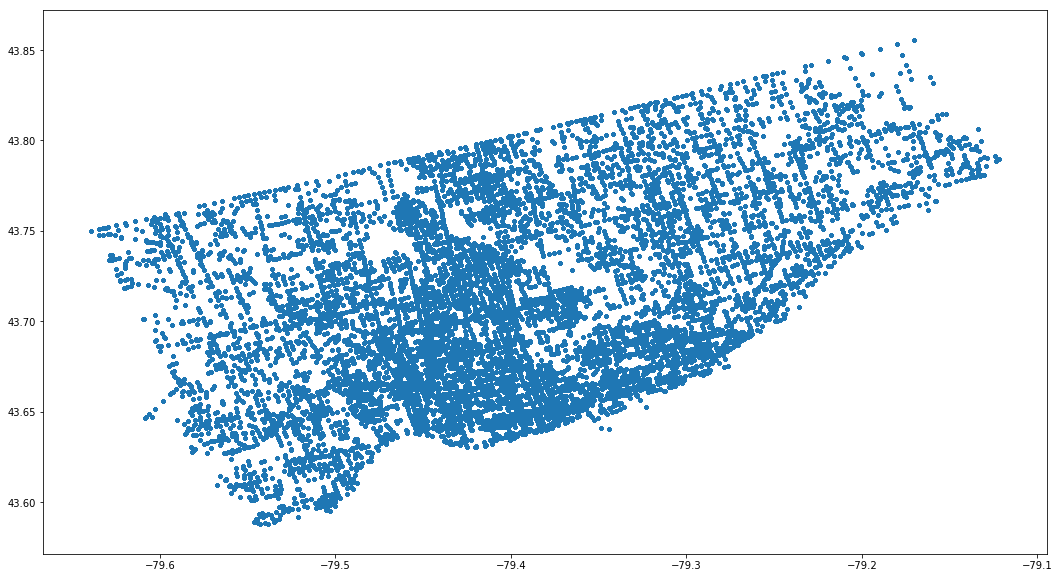

In [104]:
X=combined.loc[:,['longitude','latitude']].values

plt.figure(figsize=(18,10))
plt.scatter(X[:,0],X[:,1], s =10)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

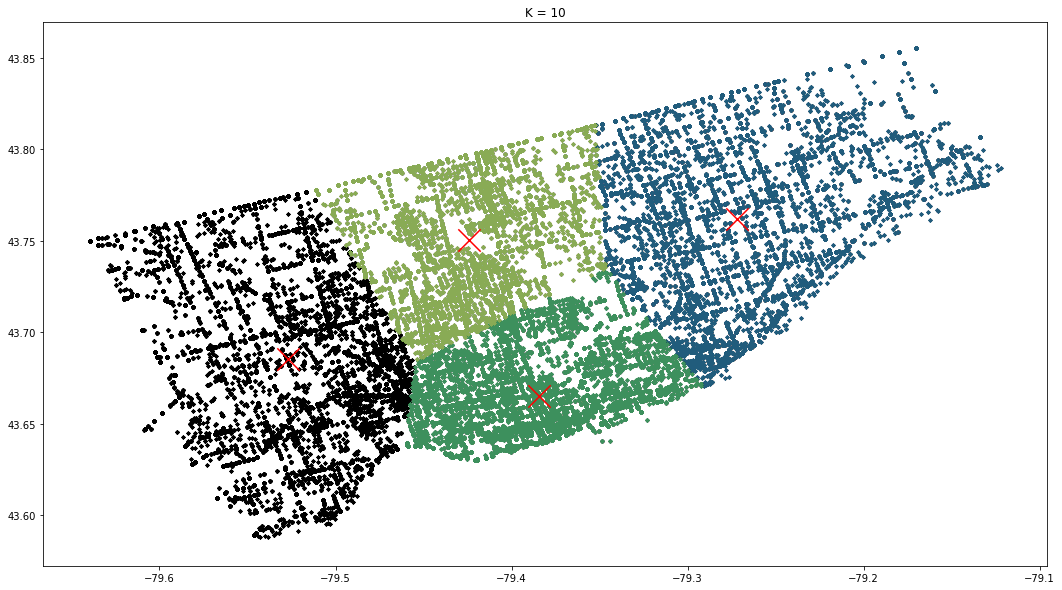

In [105]:
num_clusters = 4

k_cluster = []
k_grouping = []

cycle = plt.get_cmap("gist_earth")

kmeans = KMeans(n_clusters = num_clusters, init = 'k-means++', max_iter = 300, n_init =11, random_state =0)
y_kmeans = kmeans.fit_predict(X)
plt.figure(figsize=(18,10))
plt.title('K = 10')
for i in range(num_clusters):
    k_cluster = [kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1]]
    plt.scatter(X[y_kmeans == i,0], X[y_kmeans == i,1], s=5, c=cycle(i*50), label = 'Cluster 1')
    plt.scatter(kmeans.cluster_centers_[i,0], kmeans.cluster_centers_[i,1], s=500, c = 'red', marker = 'x', label = 'Centroids') 

plt.show()

In [106]:
combined['cluster'] = pd.Series(y_kmeans, index=combined.index)

(-79.6, -79.2)

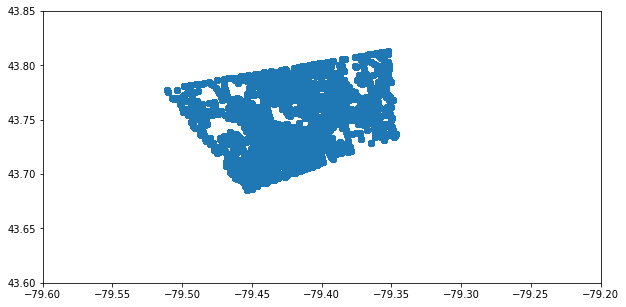

In [107]:
# Plotting a Sample Cluster #54
cluster_54 = combined[combined['cluster'] == 3]
cluster_54_lat = cluster_54['latitude']
cluster_54_long = cluster_54['longitude']
plt.figure(figsize=(10,5))
plt.scatter(cluster_54_long, cluster_54_lat)
plt.ylim(43.6, 43.85)
plt.xlim(-79.6, -79.2)

In [108]:
combined.to_csv('_combined_lookup.csv')

### <u><a name="D1.4.2">1.4.2 Creating Weather Lookup Table</a></u>

We wanted to use weather features as input to our model, i.e road_surface_condition and visibility, thus we needed to create a weather lookup table when generating negative samples. These two features can only be found through the original *Collisions - Involved* dataset, and there is not enough number of weather data points to allow the negative samples to be freely selected by any hour of the day, and any location. Therefore, we make the following assumptions:
1. If a certain weather has occured at some location, this will likely to be true for a large portion of the city.
2. If a certain weather has occured at some time, this will likely to be true for a large duration of the day.

Based on the assumption above, we have clustered the location lookup table into 4 clusters, dividing the city of toronto into 4, and have divided the time of the day into 4 aswell, assuming that the most frequenly occured weather feature within a cluster, a time division and a day is true for the entire cluster, time division of that day.

Finally, because the collision_events dataset is a subset of the location lookup table, we can map the cluster in the location lookup table to the collision_events dataset which gives the weather lookup table. This mapping ensures that the the different datasets have matching clusters.

In [109]:
collision_events=pd.read_csv('_collisions_events_processed_v4.csv')

In [110]:
collision_events=collision_events.drop(['Unnamed: 0'],axis=1)
collision_events.head()

,px,year,day_of_week,hour,collision_id,collision_date,collision_time,visibility,light,road_surface_cond,...,centerline_id,day,vehicles_involved,volume_data_veh,road_type,posted_speed,traffic_control,num_of_lane,lane_width,frequency
0,325.0,2008,weekday,7,49,2008-01-01,740,SNOW,DAYLIGHT,WET,...,10865133.0,01-01,2.0,2520.0,AT INTERSECTION,40.0,TRAFFIC SIGNAL,4.0,3.200000,0.000794
1,1356.0,2008,weekday,11,72,2008-01-01,1110,SNOW,DAYLIGHT,SLUSH,...,107897.0,01-01,2.0,2630.0,AT INTERSECTION,60.0,TRAFFIC SIGNAL,6.0,3.866667,0.000760
2,1363.0,2008,weekday,14,92,2008-01-01,1434,CLEAR,DAYLIGHT,LOOSE SNOW,...,103265.0,01-01,4.0,3325.0,AT INTERSECTION,60.0,TRAFFIC SIGNAL,6.0,3.716667,0.001203
3,397.0,2008,weekday,17,108,2008-01-01,1700,CLEAR,DUSK,DRY,...,7423543.0,01-01,1.0,3135.0,Major Arterial Road,60.0,NO CONTROL,6.0,4.000000,0.000319
4,128.0,2008,weekday,8,135,2008-01-02,817,CLEAR,DAYLIGHT,WET,...,9011793.0,01-02,2.0,3852.0,Major Arterial Road,60.0,TRAFFIC SIGNAL,4.0,4.575000,0.000519


In [111]:
combined_lookup=pd.read_csv('_combined_lookup.csv')

In [112]:
combined_lookup=combined_lookup.drop(['Unnamed: 0'], axis=1)

combined_lookup.head()

,avg_volume_per_hour,centerline_id,class_type,day_of_week,hour,lane_width,latitude,longitude,num_of_lane,posted_spd,px,road_type,year,cluster
0,11.000000,117.0,Vehicles,weekday,0.0,4.25,43.718205,-79.367974,2.0,40.0,NaN,Local Road,2001.0,2
1,4.333333,117.0,Vehicles,weekday,1.0,4.25,43.718205,-79.367974,2.0,40.0,NaN,Local Road,2001.0,2
2,1.333333,117.0,Vehicles,weekday,2.0,4.25,43.718205,-79.367974,2.0,40.0,NaN,Local Road,2001.0,2
3,2.333333,117.0,Vehicles,weekday,3.0,4.25,43.718205,-79.367974,2.0,40.0,NaN,Local Road,2001.0,2
4,4.666667,117.0,Vehicles,weekday,4.0,4.25,43.718205,-79.367974,2.0,40.0,NaN,Local Road,2001.0,2


In [113]:
kmeans_dict = combined_lookup.set_index(['centerline_id']).to_dict()['cluster']

In [114]:
collision_events['cluster']=collision_events['centerline_id'].map(kmeans_dict)

In [115]:
collision_events.head()

,px,year,day_of_week,hour,collision_id,collision_date,collision_time,visibility,light,road_surface_cond,...,day,vehicles_involved,volume_data_veh,road_type,posted_speed,traffic_control,num_of_lane,lane_width,frequency,cluster
0,325.0,2008,weekday,7,49,2008-01-01,740,SNOW,DAYLIGHT,WET,...,01-01,2.0,2520.0,AT INTERSECTION,40.0,TRAFFIC SIGNAL,4.0,3.200000,0.000794,2.0
1,1356.0,2008,weekday,11,72,2008-01-01,1110,SNOW,DAYLIGHT,SLUSH,...,01-01,2.0,2630.0,AT INTERSECTION,60.0,TRAFFIC SIGNAL,6.0,3.866667,0.000760,1.0
2,1363.0,2008,weekday,14,92,2008-01-01,1434,CLEAR,DAYLIGHT,LOOSE SNOW,...,01-01,4.0,3325.0,AT INTERSECTION,60.0,TRAFFIC SIGNAL,6.0,3.716667,0.001203,1.0
3,397.0,2008,weekday,17,108,2008-01-01,1700,CLEAR,DUSK,DRY,...,01-01,1.0,3135.0,Major Arterial Road,60.0,NO CONTROL,6.0,4.000000,0.000319,1.0
4,128.0,2008,weekday,8,135,2008-01-02,817,CLEAR,DAYLIGHT,WET,...,01-02,2.0,3852.0,Major Arterial Road,60.0,TRAFFIC SIGNAL,4.0,4.575000,0.000519,3.0


In [116]:
ndrop=['cluster', 'visibility', 'road_surface_cond', 'hour', 'collision_date'] #what we are keeping
drop=list(collision_events)
for x in ndrop:
    drop.remove(x)
collision_events_drop=collision_events.drop(columns=drop)
collision_events_drop.head()

,hour,collision_date,visibility,road_surface_cond,cluster
0,7,2008-01-01,SNOW,WET,2.0
1,11,2008-01-01,SNOW,SLUSH,1.0
2,14,2008-01-01,CLEAR,LOOSE SNOW,1.0
3,17,2008-01-01,CLEAR,DRY,1.0
4,8,2008-01-02,CLEAR,WET,3.0


In [117]:
collision_events_drop.hour.unique()

array([ 7, 11, 14, 17,  8,  9, 10, 16, 13, 15, 12, 18,  2,  1,  4, 23,  5,
       19,  0, 20, 21, 22,  3,  6])

In [118]:
def time_div (x):
    if (0<=x<6): div='dawn'
    elif (6<=x<12):div='morn'
    elif (12<=x<18): div='afternoon'
    elif  (18<=x): div='dusk'
    return div

In [119]:
# testdata.map(lambda x: x if (x < 30 or x > 60) else 0)
collision_events_drop['time_div']=collision_events_drop.hour.apply(time_div)

In [120]:
collision_events_drop.time_div.unique()

array(['morn', 'afternoon', 'dusk', 'dawn'], dtype=object)

In [121]:
collision_events_drop.visibility.unique()

array(['SNOW', 'CLEAR', 'RAIN', 'FREEZING RAIN', 'STRONG WIND', 'OTHER',
       'FOG, MIST, SMOKE, DUST', 'DRIFTING SNOW', nan], dtype=object)

In [122]:
collision_events_drop=collision_events_drop.dropna(subset=['visibility','road_surface_cond'])
collision_events_drop[(collision_events_drop.visibility.isna()) & (collision_events_drop.road_surface_cond.isna())]

,hour,collision_date,visibility,road_surface_cond,cluster,time_div


In [123]:
#took the most frequent occurance of visibility, and road_surface_condition for the given time_division, date and cluster
collision_events_drop=collision_events_drop.groupby(['time_div','collision_date','cluster']).agg(lambda x: x.value_counts().index[0])

In [124]:
collision_events_drop.head()

hour visibility road_surface_cond
time_div  collision_date cluster                                   
afternoon 2008-01-01     1.0        14      CLEAR        LOOSE SNOW
                         2.0        12       SNOW        LOOSE SNOW
                         3.0        15      CLEAR             SLUSH
          2008-01-02     0.0        17      CLEAR               DRY
                         1.0        17      CLEAR               DRY

In [125]:
collision_events_drop=collision_events_drop.reset_index(['time_div','collision_date','cluster'])
collision_events_drop.head()

,time_div,collision_date,cluster,hour,visibility,road_surface_cond
0,afternoon,2008-01-01,1.0,14,CLEAR,LOOSE SNOW
1,afternoon,2008-01-01,2.0,12,SNOW,LOOSE SNOW
2,afternoon,2008-01-01,3.0,15,CLEAR,SLUSH
3,afternoon,2008-01-02,0.0,17,CLEAR,DRY
4,afternoon,2008-01-02,1.0,17,CLEAR,DRY


In [126]:
collision_events_drop.to_csv('_weather_lookup.csv')
collision_events.to_csv('_collision_events_4cluster.csv')

### <u><a name="D1.5">1.5 Generate Negative Samples</a></u>

In [127]:
import random
from IPython.display import clear_output

#setting a random seed so the result is repeatable.
random.seed(9001)

In [128]:
collision_events=pd.read_csv('_collision_events_4cluster.csv')

In [129]:
collision_events=collision_events.drop(['Unnamed: 0'], axis=1)
collision_events.head()

,px,year,day_of_week,hour,collision_id,collision_date,collision_time,visibility,light,road_surface_cond,...,day,vehicles_involved,volume_data_veh,road_type,posted_speed,traffic_control,num_of_lane,lane_width,frequency,cluster
0,325.0,2008,weekday,7,49,2008-01-01,740,SNOW,DAYLIGHT,WET,...,01-01,2.0,2520.0,AT INTERSECTION,40.0,TRAFFIC SIGNAL,4.0,3.200000,0.000794,2.0
1,1356.0,2008,weekday,11,72,2008-01-01,1110,SNOW,DAYLIGHT,SLUSH,...,01-01,2.0,2630.0,AT INTERSECTION,60.0,TRAFFIC SIGNAL,6.0,3.866667,0.000760,1.0
2,1363.0,2008,weekday,14,92,2008-01-01,1434,CLEAR,DAYLIGHT,LOOSE SNOW,...,01-01,4.0,3325.0,AT INTERSECTION,60.0,TRAFFIC SIGNAL,6.0,3.716667,0.001203,1.0
3,397.0,2008,weekday,17,108,2008-01-01,1700,CLEAR,DUSK,DRY,...,01-01,1.0,3135.0,Major Arterial Road,60.0,NO CONTROL,6.0,4.000000,0.000319,1.0
4,128.0,2008,weekday,8,135,2008-01-02,817,CLEAR,DAYLIGHT,WET,...,01-02,2.0,3852.0,Major Arterial Road,60.0,TRAFFIC SIGNAL,4.0,4.575000,0.000519,3.0


In [130]:
collision_events.shape

(45359, 23)

In [131]:
collision_events.columns.values

array(['px', 'year', 'day_of_week', 'hour', 'collision_id',
       'collision_date', 'collision_time', 'visibility', 'light',
       'road_surface_cond', 'longitude', 'latitude', 'centerline_id',
       'day', 'vehicles_involved', 'volume_data_veh', 'road_type',
       'posted_speed', 'traffic_control', 'num_of_lane', 'lane_width',
       'frequency', 'cluster'], dtype=object)

In [132]:
#Here we clean up the list of positive samples (i.e collision events) to keep the features that we want
ndrop=['px', 'day_of_week', 'collision_date', 'visibility', 'road_surface_cond',
       'centerline_id','volume_data_veh', 'road_type',
       'posted_speed', 'num_of_lane', 'lane_width','cluster','hour','year', 'longitude', 'latitude'] #what we are keeping
drop=list(collision_events)
for x in ndrop:
    drop.remove(x)
collision_events_drop=collision_events.drop(columns=drop)
collision_events_drop.head()

,px,year,day_of_week,hour,collision_date,visibility,road_surface_cond,longitude,latitude,centerline_id,volume_data_veh,road_type,posted_speed,num_of_lane,lane_width,cluster
0,325.0,2008,weekday,7,2008-01-01,SNOW,WET,-79.435600,43.659800,10865133.0,2520.0,AT INTERSECTION,40.0,4.0,3.200000,2.0
1,1356.0,2008,weekday,11,2008-01-01,SNOW,SLUSH,-79.252403,43.774502,107897.0,2630.0,AT INTERSECTION,60.0,6.0,3.866667,1.0
2,1363.0,2008,weekday,14,2008-01-01,CLEAR,LOOSE SNOW,-79.317100,43.821300,103265.0,3325.0,AT INTERSECTION,60.0,6.0,3.716667,1.0
3,397.0,2008,weekday,17,2008-01-01,CLEAR,DRY,-79.216000,43.761800,7423543.0,3135.0,Major Arterial Road,60.0,6.0,4.000000,1.0
4,128.0,2008,weekday,8,2008-01-02,CLEAR,WET,-79.415800,43.779700,9011793.0,3852.0,Major Arterial Road,60.0,4.0,4.575000,3.0


In [133]:
#Cleaning up the NA values in the list of positive samples
#filling na values according to ontario regulation, which is 50km/hr if no explicitly stated speed limit
collision_events_drop.posted_speed=collision_events_drop.posted_speed.fillna(50.0);
collision_events_drop.posted_speed=collision_events_drop.posted_speed.apply(lambda x: 50 if (x==0) else x);
collision_events_drop.posted_speed=collision_events_drop.posted_speed.apply(lambda x: 40 if (x==4) else x);
collision_events_drop.posted_speed=collision_events_drop.posted_speed.apply(lambda x: 30 if (x==3) else x);
collision_events_drop.posted_speed=collision_events_drop.posted_speed.apply(lambda x: 60 if (x==59) else x);
#filling na values with mean
collision_events_drop.num_of_lane=collision_events_drop.num_of_lane.fillna(4.0);
#filling na values with mean
collision_events_drop.lane_width=collision_events_drop.lane_width.fillna(4.1);

In [134]:
collision_events_drop.shape

(45359, 16)

In [135]:
collision_events_drop = collision_events_drop[collision_events_drop.year >= 2008]
collision_events_drop.head()

,px,year,day_of_week,hour,collision_date,visibility,road_surface_cond,longitude,latitude,centerline_id,volume_data_veh,road_type,posted_speed,num_of_lane,lane_width,cluster
0,325.0,2008,weekday,7,2008-01-01,SNOW,WET,-79.435600,43.659800,10865133.0,2520.0,AT INTERSECTION,40.0,4.0,3.200000,2.0
1,1356.0,2008,weekday,11,2008-01-01,SNOW,SLUSH,-79.252403,43.774502,107897.0,2630.0,AT INTERSECTION,60.0,6.0,3.866667,1.0
2,1363.0,2008,weekday,14,2008-01-01,CLEAR,LOOSE SNOW,-79.317100,43.821300,103265.0,3325.0,AT INTERSECTION,60.0,6.0,3.716667,1.0
3,397.0,2008,weekday,17,2008-01-01,CLEAR,DRY,-79.216000,43.761800,7423543.0,3135.0,Major Arterial Road,60.0,6.0,4.000000,1.0
4,128.0,2008,weekday,8,2008-01-02,CLEAR,WET,-79.415800,43.779700,9011793.0,3852.0,Major Arterial Road,60.0,4.0,4.575000,3.0


In [136]:
collision_events_drop.shape

(45359, 16)

Creating a set of negative dataset. Aim to create about 3 times more negative samples as the positive samples, based on the papers that we've read. 

#### <u><a name="D1.5.1">1.5.1 Cleaning Lookup Tables</a></u>

In [137]:
lookup=pd.read_csv('_combined_lookup.csv').drop(['Unnamed: 0'],axis=1)
lookup_weather = pd.read_csv('_weather_lookup.csv').drop(['Unnamed: 0'],axis=1)

In [138]:
print(lookup.shape)
print(lookup_weather.shape)

(1317556, 14)
(22308, 6)


In [139]:
lookup_weather_temp = lookup_weather.copy()
lookup_weather_temp['collision_date']=pd.to_datetime(lookup_weather.collision_date)
lookup_weather['day_of_week'] = lookup_weather_temp.collision_date.dt.dayofweek.apply(lambda x : 'weekday' if(x<5) else 'weekend')
lookup_weather['year'] = lookup_weather_temp.collision_date.dt.year
lookup_weather = lookup_weather[lookup_weather.year>=2008]
lookup_weather_temp = None
lookup_weather.head()

,time_div,collision_date,cluster,hour,visibility,road_surface_cond,day_of_week,year
0,afternoon,2008-01-01,1.0,14,CLEAR,LOOSE SNOW,weekday,2008
1,afternoon,2008-01-01,2.0,12,SNOW,LOOSE SNOW,weekday,2008
2,afternoon,2008-01-01,3.0,15,CLEAR,SLUSH,weekday,2008
3,afternoon,2008-01-02,0.0,17,CLEAR,DRY,weekday,2008
4,afternoon,2008-01-02,1.0,17,CLEAR,DRY,weekday,2008


In [140]:
#filling na values according to ontario regulation
lookup.posted_spd =lookup.posted_spd.fillna(50.0);
lookup.posted_spd=lookup.posted_spd.apply(lambda x: 50 if (x==0) else x);
lookup.posted_spd=lookup.posted_spd.apply(lambda x: 40 if (x==4) else x);
lookup.posted_spd=lookup.posted_spd.apply(lambda x: 30 if (x==3) else x);
lookup.posted_spd=lookup.posted_spd.apply(lambda x: 60 if (x==59) else x);
#filling na values with mean
lookup.num_of_lane=lookup.num_of_lane.fillna(4.0);
#filling na values with mean
lookup.lane_width=lookup.lane_width.fillna(4.1);

In [141]:
lookup = lookup[lookup.year>=2008]

#only include motor vehicle collisions
lookup = lookup[lookup.class_type == 'Vehicles']
lookup.head()

,avg_volume_per_hour,centerline_id,class_type,day_of_week,hour,lane_width,latitude,longitude,num_of_lane,posted_spd,px,road_type,year,cluster
24,7.0,117.0,Vehicles,weekday,0.0,4.25,43.718205,-79.367974,2.0,40.0,NaN,Local Road,2009.0,2
25,2.0,117.0,Vehicles,weekday,1.0,4.25,43.718205,-79.367974,2.0,40.0,NaN,Local Road,2009.0,2
26,0.0,117.0,Vehicles,weekday,2.0,4.25,43.718205,-79.367974,2.0,40.0,NaN,Local Road,2009.0,2
27,2.0,117.0,Vehicles,weekday,3.0,4.25,43.718205,-79.367974,2.0,40.0,NaN,Local Road,2009.0,2
28,4.0,117.0,Vehicles,weekday,4.0,4.25,43.718205,-79.367974,2.0,40.0,NaN,Local Road,2009.0,2


In [142]:
print(lookup.shape)
print(lookup_weather.shape)

(463368, 14)
(22308, 8)


In [143]:
#set unique location keys:
lookup.px=lookup.px.fillna('not_intersection')
lookup = lookup.set_index(['px', 'centerline_id', 'cluster','hour','day_of_week','year'])
lookup['location_id'] = lookup.index.tolist()
lookup = lookup.reset_index(['px', 'centerline_id', 'cluster','hour','day_of_week','year'])
location_id_list=lookup.location_id.unique()

In [144]:
#set unique time keys:
lookup_weather = lookup_weather.set_index(['collision_date', 'time_div','cluster'])
lookup_weather['time_id'] = lookup_weather.index.tolist()
lookup_weather = lookup_weather.reset_index(['collision_date', 'time_div','cluster'])

In [145]:
#set unique keys in collision data:
collision_events_drop.px=collision_events_drop.px.fillna('not_intersection')
collision_events_drop = collision_events_drop.set_index(['px', 'centerline_id', 'cluster','hour','day_of_week','collision_date'])
collision_events_drop['unique_id'] = collision_events_drop.index.tolist()
collision_events_drop = collision_events_drop.reset_index(['px', 'centerline_id', 'cluster','hour','day_of_week','collision_date'])

In [146]:
def time_div_func (x):
    if (0<=x<6): div='dawn'
    elif (6<=x<12):div='morn'
    elif (12<=x<18): div='afternoon'
    elif  (18<=x): div='dusk'
    return div

#### <u><a name="D1.5.2">1.5.2 Negative Sample Generator</a></u>

In [147]:
%%skip $marking

negative_samples = []
j=0
for i in range (2):
    #select location for spacial data:
    ID=random.randint(0,len(location_id_list)-1)
    location_id =location_id_list[ID]

    cluster = location_id_list[ID][2]
    time_div = 'morn'
    day_of_week = location_id_list[ID][4]
    year = location_id_list[ID][5]


    #select date for weather data:
    lookup_weather_possible = lookup_weather[(lookup_weather.cluster == cluster) & (lookup_weather.time_div == time_div) & (lookup_weather.day_of_week== day_of_week) & (lookup_weather.year == year) ].time_id.values
    if len(lookup_weather_possible) > 0:
        ID3=random.randint(0,len(lookup_weather_possible)-1)
        weather_id = lookup_weather_possible[ID3]
        unique_id = (location_id[0],location_id[1],location_id[2],location_id[3],location_id[4],weather_id[0])
        find = len(collision_events_drop[collision_events_drop.unique_id == unique_id])
    else:
        find = 1
        
    if (find == 0) and ([location_id,weather_id] not in negative_samples) :
        negative_samples.append([location_id,weather_id])
        
    j+=1    
    if (j==500):
        clear_output()
        j=0
        print(i)
        print(len(negative_samples))

In [148]:
%%skip $marking

len(negative_samples)

In [149]:
%%skip $marking

collision_events_all=collision_events_drop.drop(columns='unique_id')
collision_events_all['target'] = 1

In [150]:
%%skip $marking

j=0
for i in range(len(negative_samples)):

    location = lookup[lookup.location_id == negative_samples[i][0]]
    weather = lookup_weather[lookup_weather.time_id == negative_samples[i][1]]

    collision_events_all = collision_events_all.append({'px':negative_samples[i][0][0],
                                                        'centerline_id':negative_samples[i][0][1],
                                                        'cluster':negative_samples[i][0][2],
                                                        'hour':negative_samples[i][0][3],
                                                        'day_of_week': negative_samples[i][0][4],
                                                        'collision_date':weather.collision_date.values[0],
                                                        'visibility':weather.visibility.values[0],
                                                        'road_surface_cond':weather.road_surface_cond.values[0],
                                                        'volume_data_veh':location.avg_volume_per_hour.values[0],
                                                        'road_type':location.road_type.values[0],
                                                        'posted_speed':location.posted_spd.values[0],
                                                        'num_of_lane':location.num_of_lane.values[0],
                                                        'lane_width':location.lane_width.values[0],
                                                        'longitude':location.longitude.values[0],
                                                        'latitude':location.latitude.values[0],
                                                        'target':0},ignore_index=True)
    j+=1    
    if (j==500):
        clear_output()
        j=0
        print(i)                                       

In [151]:
%%skip $marking

collision_events_all['month']=collision_events_all.collision_date.apply(lambda x: str(x)[5:7])
collision_events_all['year']=collision_events_all.collision_date.apply(lambda x: str(x)[0:4])

In [152]:
%%skip $marking

collision_events_all

In [153]:
%%skip $marking

for parameter in collision_events_all:
    print(parameter, ',', collision_events_all[parameter].hasnans, ',', collision_events_all[parameter].isna().sum())

In [154]:
%%skip $marking

drop=list(collision_events_all)
collision_events_all=collision_events_all.dropna(subset=drop)

In [155]:
%%skip $marking

collision_events_all.to_csv('_collisions_events_processed_v7.csv')
del collision_events_all

#### <u><a name="D1.5.3">1.5.3 Perform K-Clustering on the Full Dataset</a></u>

In [156]:
collision_events_all=pd.read_csv('_collisions_events_processed_v7.csv')

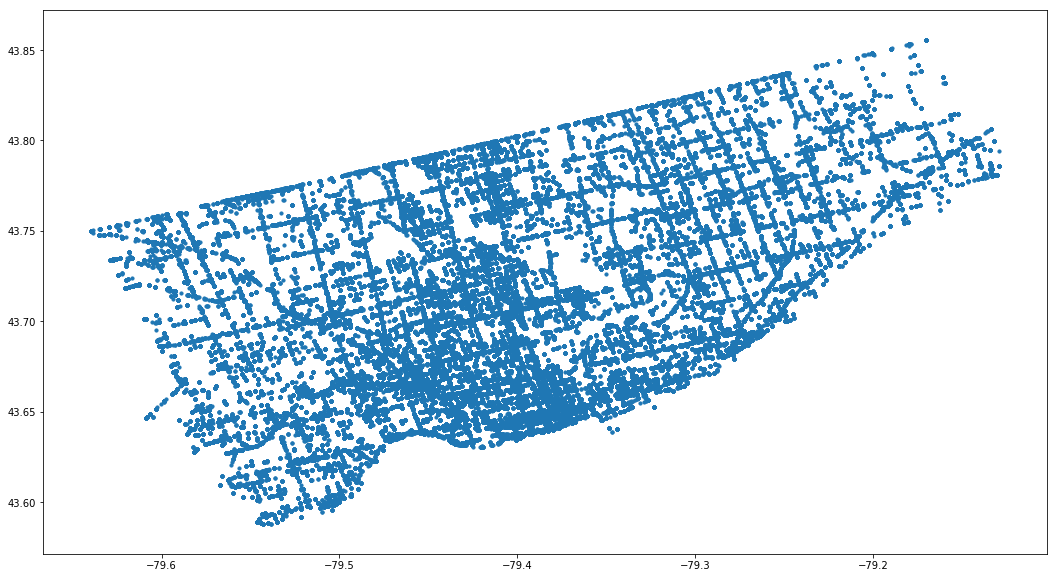

In [157]:
X=collision_events_all.loc[:,['longitude','latitude']].values

plt.figure(figsize=(18,10))
plt.scatter(X[:,0],X[:,1], s =10)

In [158]:
%%skip $marking
# Plotting the Clusters and its Centroids
cluster_list=[4,10,20,30,40]
for j in cluster_list:
    num_clusters = j
    k_cluster = []
    k_grouping = []

    cycle = plt.get_cmap("gist_earth")

    kmeans = KMeans(n_clusters = num_clusters, init = 'k-means++', max_iter = 300, n_init =11, random_state =0)
    y_kmeans = kmeans.fit_predict(X)
    plt.figure(figsize=(18,10))
    plt.title('K = '+str(j))
    for i in range(num_clusters):
        k_cluster = [kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1]]
        plt.scatter(X[y_kmeans == i,0], X[y_kmeans == i,1], s=5, c=cycle(i*5), label = 'Cluster 1')
        plt.scatter(kmeans.cluster_centers_[i,0], kmeans.cluster_centers_[i,1], s=500, c = 'red', marker = 'x', label = 'Centroids') 

    plt.show()

    # Dataset with a new column "Cluster"
    collision_events_all['k_cluster'] = pd.Series(y_kmeans)
    collision_events_all_to_export = collision_events_all.drop(columns=['px','centerline_id','collision_date','year','cluster','Unnamed: 0',])
    collision_events_all_to_export.to_csv('_collisions_events_processed_v7_k'+str(j)+'.csv')

###  <u><a name="DV">2.0 Data Visualization</a></u>

In [159]:
collision_events_plot = pd.read_csv('_collisions_events_processed_v7_k'+str(4)+'.csv')
collision_events_all_plot=pd.read_csv('_collisions_events_processed.csv', low_memory=False)

In [160]:
# defining bar plot with two bars ploting functions:
def plot_two_bar(neg, pos, labels, Title,width=0.4):
    
    fig, ax = plt.subplots()
    
    ind = np.arange(len(labels))    
    width = 0.45

    p1 = plt.bar(ind, neg, width,alpha= 0.8,label='No Collision')
    p2 = plt.bar(ind, pos, width,color='indianred',alpha= 0.8, bottom=neg,label='Collision')
    
    plt.title(Title, fontsize=16)
    plt.xticks(ind, labels)
    plt.xticks(rotation=-75)
    plt.legend()

In [161]:
# Defining bar plot plotting functions:
def plot_one_bar(value, labels, Title,ylabel,xlabel, width=0.4):
    
    fig, ax = plt.subplots()
    
    ind = np.arange(len(labels))    
    width = 0.45

    p1 = plt.bar(ind, value, width,alpha= 0.8)

    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(Title, fontsize=16)
    plt.xticks(ind, labels)
    plt.xticks(rotation=-75)

Total number accident: 486697


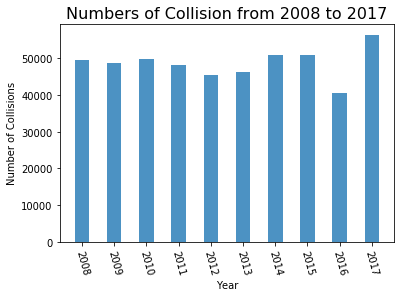

In [162]:
collision_events_all_dist = collision_events_all_plot.groupby(by='year', as_index=False).agg({'collision_date': pd.Series.count})
Title = 'Numbers of Collision from 2008 to 2017'
ylabel = 'Number of Collisions'
xlabel = "Year"

plot_one_bar(collision_events_all_dist['collision_date'], collision_events_all_dist['year'], Title, ylabel,xlabel)
print('Total number accident: '+ str(collision_events_all_dist['collision_date'].sum()))

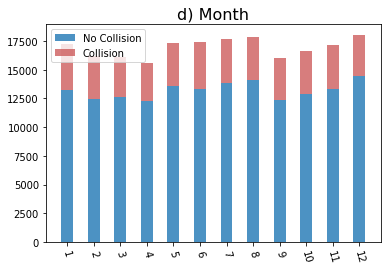

In [163]:
collision_events_dist = pd.pivot_table(collision_events_plot, values='Unnamed: 0', index=['month'], columns=['target'], aggfunc='count')
collision_events_dist= collision_events_dist.reset_index()
neg = collision_events_dist[0]
pos = collision_events_dist[1]
labels = collision_events_dist['month']
Title = 'd) Month'

plot_two_bar(neg, pos, labels, Title)

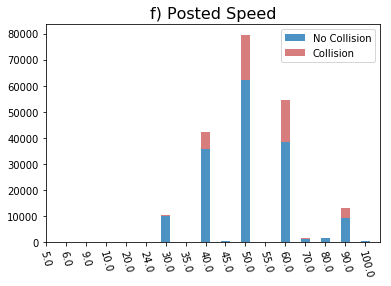

In [164]:
collision_events_dist = pd.pivot_table(collision_events_plot, values='longitude', index=['posted_speed'], columns=['target'], aggfunc='count')
collision_events_dist= collision_events_dist.reset_index()
neg = collision_events_dist[0]
pos = collision_events_dist[1]
labels = collision_events_dist['posted_speed']
Title = 'f) Posted Speed'

plot_two_bar(neg, pos, labels, Title)

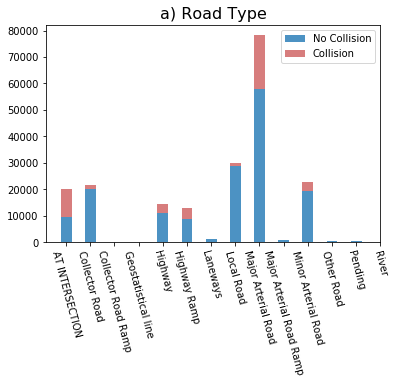

In [165]:
collision_events_dist = pd.pivot_table(collision_events_plot, values='Unnamed: 0', index=['road_type'], columns=['target'], aggfunc='count')
collision_events_dist= collision_events_dist.reset_index()
neg = collision_events_dist[0]
pos = collision_events_dist[1]
labels = collision_events_dist['road_type']
Title = 'a) Road Type'

plot_two_bar(neg, pos, labels, Title)

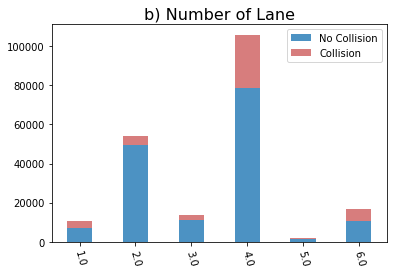

In [166]:
collision_events_dist = pd.pivot_table(collision_events_plot, values='Unnamed: 0', index=['num_of_lane'], columns=['target'], aggfunc='count')
collision_events_dist= collision_events_dist.reset_index()
neg = collision_events_dist[0]
pos = collision_events_dist[1]
labels = collision_events_dist['num_of_lane']
Title = 'b) Number of Lane'

plot_two_bar(neg, pos, labels, Title)

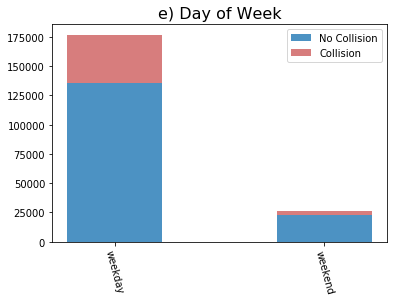

In [167]:
collision_events_dist = pd.pivot_table(collision_events_plot, values='Unnamed: 0', index=['day_of_week'], columns=['target'], aggfunc='count')
collision_events_dist= collision_events_dist.reset_index()
neg = collision_events_dist[0]
pos = collision_events_dist[1]
labels = collision_events_dist['day_of_week']
Title = 'e) Day of Week'

plot_two_bar(neg, pos, labels, Title)

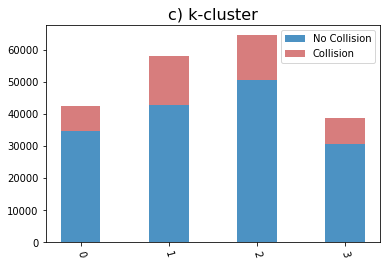

In [168]:
collision_events_dist = pd.pivot_table(collision_events_plot, values='Unnamed: 0', index=['k_cluster'], columns=['target'], aggfunc='count')
collision_events_dist= collision_events_dist.reset_index()
neg = collision_events_dist[0]
pos = collision_events_dist[1]
labels = collision_events_dist['k_cluster']
Title = 'c) k-cluster'

plot_two_bar(neg, pos, labels, Title)

## <u><a name="MI">3.0 Model Implemtation</a></u>


In this section, we examine which classifier model should be implemented. Given this dataset is very computationally intensive, we only compare two classifiers that was identified to have the potential to perform well through literature review. For each of the classifer, the effect of different K clusters are also evaluated. The classifer and number of K clusters that is shown to be better will be selected for traffic accident classifer, and then further tuned with random grid search.

The models are stored in a  `.pickle` file so that they may persist after the notebook is closed, and can be read in when needed.

The training of the model are recommended to be skipped given that it is computationally expensive to train the classifers. 


### <u><a name="MI3.1">3.1 Random Forest</a></u>

In [169]:
!pip install joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump, load
sns.set_style('whitegrid')
%matplotlib inline

import time
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

/home/richard/.local/lib/python2.7/site-packages/pip/_vendor/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


####  <u><a name="MI3.1.1">3.1.1 Model Fitting</a></u>

We represent categorical features as binary with dummy variables here because scikit-learn only takes in numercial inputs. The categories are weekday/weekend, visibility, road_surface condition, road_type, month, hour and K_cluster. The numerical features are vehicle traffic volume, lane width, number of lanes, and posted speed limit.

In [170]:
%%skip $marking
cluster_list=[4,10,20,30,40] # 
for j in cluster_list:
    #Read the corresponding CSV file:
    df = pd.read_csv('_collisions_events_processed_v7_k'+str(j)+'.csv')
    df=df.drop(columns=['Unnamed: 0'],axis=1)
    df.rename(columns={'day_of_week':'day',
                       'classed_visibility':'visibility',
                       'num_of_lane':'lane_num'}, 
                     inplace=True)
    
    # Change all text data to lower case letters:
    df['day']=df['day'].apply(lambda x: x.lower())
    df['visibility']=df['visibility'].apply(lambda x: x.lower())
    df['road_surface_cond']=df['road_surface_cond'].apply(lambda x: x.lower())
    df['road_type']=df['road_type'].apply(lambda x: x.lower())
    
    # Discritize all categorical data into binary data:
    df['day']=pd.Categorical(df['day'])
    dfday = pd.get_dummies(df['day'])
    df=pd.concat([dfday['weekday'],df], axis=1)

    df['visibility']=pd.Categorical(df['visibility'])
    dfvisibility = pd.get_dummies(df['visibility'],prefix = 'visibility')
    df=pd.concat([dfvisibility,df], axis=1)

    df['road_surface_cond']=pd.Categorical(df['road_surface_cond'])
    dfroad_surface = pd.get_dummies(df['road_surface_cond'],prefix = 'road_surface')
    df=pd.concat([dfroad_surface,df], axis=1)

    df['road_type']=pd.Categorical(df['road_type'])
    dfroad_type = pd.get_dummies(df['road_type'],prefix = 'road_type')
    df=pd.concat([dfroad_type,df], axis=1)

    df['month']=pd.Categorical(df['month'])
    dfroad_type = pd.get_dummies(df['month'],prefix = 'month')
    df=pd.concat([dfroad_type,df], axis=1)

    df['k_cluster']=pd.Categorical(df['k_cluster'])
    dfroad_type = pd.get_dummies(df['k_cluster'],prefix = 'k_cluster')
    df=pd.concat([dfroad_type,df], axis=1)

    df['hour']=pd.Categorical(df['hour'])
    dfroad_type = pd.get_dummies(df['hour'],prefix = 'hour')
    df=pd.concat([dfroad_type,df], axis=1)

    #dropping data that was discritized
    df=df.drop(columns=['day', 'road_type', 'visibility', 'road_surface_cond', 'k_cluster', 'hour', 'month','longitude','latitude'])
    
    # Define target and input features:
    X = df.iloc[:, 0:-1].values  
    y = df.iloc[:, -1].values

    # Split data into 2/3 training and 1/3 testing data:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 
    start = time.clock()
    
    #fitting the model
    clf = RandomForestClassifier(n_estimators=500, random_state=42)  
    clf.fit(X_train, y_train) 
    
    #evaluating the model
    y_pred = clf.predict(X_test)
    
    #printint out model runtimes
    print("For K="+str(j))
    print('runtime: '+str(time.clock() - start)+'\n')
    
    #pickling the model outputs
    tmp_pickle_df='_rf_k'+str(j)+'df.pickle'
    pickle_out = open(tmp_pickle_df,'wb')
    pickle.dump(df, pickle_out)
    pickle_out.close()
    
    tmp_pickle_test='_rf_k'+str(j)+'y_test.pickle'
    pickle_out = open(tmp_pickle_test,'wb')
    pickle.dump(y_test, pickle_out)
    pickle_out.close()
    
    tmp_pickle_pred='_rf_k'+str(j)+'y_pred.pickle'
    pickle_out = open(tmp_pickle_pred,'wb')
    pickle.dump(y_pred, pickle_out)
    pickle_out.close()
    
    tmp_joblib='_rf_k'+str(j)+'.joblib'
    dump(clf, tmp_joblib)

#### <u><a name="MI3.1.2">3.1.2 Presenting Model Results</a></u>

Here we present the overall accuracy and classification report of different clusters. The recall score of a  collision is what we are most interested in, as a traffic accident predictor should catch as much accidents as possible.

In [171]:
cluster_list=[4,10,20,30,40]
for j in cluster_list:
    
    #reading in pickled data files
    tmp_pickle_test='_rf_k'+str(j)+'y_test.pickle'
    pickle_in = open(tmp_pickle_test,'rb')
    y_test = pickle.load(pickle_in)
    pickle_in.close()
    
    tmp_pickle_pred='_rf_k'+str(j)+'y_pred.pickle'
    pickle_in = open(tmp_pickle_pred,'rb')
    y_pred = pickle.load(pickle_in)
    pickle_in.close()
    
    #printint model results
    print("For K="+str(j))
    print("Accuracy: %0.5f" % accuracy_score(y_test, y_pred))
    print(classification_report(y_test,y_pred, digits=5,target_names=['no collision','collision']))
    

For K=4
Accuracy: 0.90001
              precision    recall  f1-score   support

no collision    0.91264   0.96395   0.93759     52322
   collision    0.84133   0.67440   0.74867     14828

   micro avg    0.90001   0.90001   0.90001     67150
   macro avg    0.87698   0.81918   0.84313     67150
weighted avg    0.89689   0.90001   0.89588     67150

For K=10
Accuracy: 0.90463
              precision    recall  f1-score   support

no collision    0.91493   0.96757   0.94051     52322
   collision    0.85641   0.68256   0.75966     14828

   micro avg    0.90463   0.90463   0.90463     67150
   macro avg    0.88567   0.82506   0.85009     67150
weighted avg    0.90201   0.90463   0.90058     67150

For K=20
Accuracy: 0.90509
              precision    recall  f1-score   support

no collision    0.91505   0.96806   0.94081     52322
   collision    0.85835   0.68290   0.76064     14828

   micro avg    0.90509   0.90509   0.90509     67150
   macro avg    0.88670   0.82548   0.85073     

We perform cross validation for the cross validated accuracy for model with different clusters.

In [172]:
%%skip $marking
cluster_list=[4,10,20,30,40]
for j in cluster_list:
    
    #reading in pickled data files
    tmp_pickle_df='_rf_k'+str(j)+'df.pickle'
    pickle_in = open(tmp_pickle_df,'rb')
    df=pickle.load(pickle_in)
    pickle_in.close()
    
    tmp='_rf_k'+str(j)+'.joblib'
    clf=load(tmp)
    
    #performing cross validation
    X = df.iloc[:, 0:-1].values  
    y = df.iloc[:, -1].values
    print("... starting cross-validating for k="+str(j))
    start = time.clock()
    scores = cross_val_score(clf, X, y, cv=3)
    print('runtime: '+str(time.clock() - start)+'\n')
    
    #pickling cross validation result
    tmp_score='_rf_k'+str(j)+'cv_score.pickle'
    pickle_out = open(tmp_score,'wb')
    pickle.dump(scores, pickle_out)
    pickle_out.close()

In [173]:
cluster_list=[4,10,20,30,40]
for j in cluster_list:
    
    #reading in picklied cross validation result
    tmp_score='_rf_k'+str(j)+'cv_score.pickle'
    pickle_in = open(tmp_score,'rb')
    scores = pickle.load(pickle_in)
    pickle_in.close()
    
    #printint cross validation results
    print("For K="+str(j)+" Cross Validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


For K=4 Cross Validated Accuracy: 0.88 (+/- 0.06)
For K=10 Cross Validated Accuracy: 0.88 (+/- 0.06)
For K=20 Cross Validated Accuracy: 0.88 (+/- 0.06)
For K=30 Cross Validated Accuracy: 0.88 (+/- 0.06)
For K=40 Cross Validated Accuracy: 0.89 (+/- 0.07)


### <u><a name="MI3.2">3.2 Neural Nets</a></u>

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import time

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler


#### <u><a name="MI3.2.1">3.2.1 Model Fitting</a></u>

In [175]:
%%skip $marking
cluster_list=[10,20,30,40] #
for j in cluster_list:
    
    #reading in previously processed dfs
    tmp_pickle_df='_rf_k'+str(j)+'df.pickle'
    pickle_in = open(tmp_pickle_df,'rb')
    df=pickle.load(pickle_in)
    pickle_in.close()
    
    X = df.iloc[:, 0:-1].values  
    y = df.iloc[:, -1].values

    # Scale all continuous data in the range of 0 to 1:
    scaler = MinMaxScaler(feature_range=(0,1), copy=False)
    X[:,len(df.columns)-5:len(df.columns)-1]=scaler.fit_transform(X[:,len(df.columns)-5:len(df.columns)-1])

    #splitting training data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 
    
    print("For K="+str(j))
    start = time.clock()
    mlp = MLPClassifier(activation='logistic',
                        hidden_layer_sizes=(45,30,20),
                        alpha=0.000000001,
                        max_iter=600)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)  
    print(time.clock() - start)
    
    #pickling the model outputs
    tmp_pickle_df='_nn_k'+str(j)+'df.pickle'
    pickle_out = open(tmp_pickle_df,'wb')
    pickle.dump(df, pickle_out)
    pickle_out.close()
    
    tmp_pickle_test='_nn_k'+str(j)+'y_test.pickle'
    pickle_out = open(tmp_pickle_test,'wb')
    pickle.dump(y_test, pickle_out)
    pickle_out.close()
    
    tmp_pickle_pred='_nn_k'+str(j)+'y_pred.pickle'
    pickle_out = open(tmp_pickle_pred,'wb')
    pickle.dump(y_pred, pickle_out)
    pickle_out.close()
    
    tmp_joblib='_nn_k'+str(j)+'.joblib'
    dump(mlp, tmp_joblib)

#### <u><a name="MI3.2.2">3.2.2 Presenting Model Results</a></u>

In [176]:
cluster_list=[4,10,20,30,40]
for j in cluster_list:
    
    #reading in pickled data files
    tmp_pickle_test='_nn_k'+str(j)+'y_test.pickle'
    pickle_in = open(tmp_pickle_test,'rb')
    y_test = pickle.load(pickle_in)
    pickle_in.close()
    
    tmp_pickle_pred='_nn_k'+str(j)+'y_pred.pickle'
    pickle_in = open(tmp_pickle_pred,'rb')
    y_pred = pickle.load(pickle_in)
    pickle_in.close()
    
    #printint model results
    print("For K="+str(j))
    print("Neural Net Accuracy: %0.5f" % accuracy_score(y_test, y_pred))
    print(classification_report(y_test,y_pred, digits=5))
    

For K=4
Neural Net Accuracy: 0.89742
              precision    recall  f1-score   support

           0    0.90418   0.97083   0.93632     51565
           1    0.86342   0.64187   0.73634     14813

   micro avg    0.89742   0.89742   0.89742     66378
   macro avg    0.88380   0.80635   0.83633     66378
weighted avg    0.89509   0.89742   0.89170     66378

For K=10
Neural Net Accuracy: 0.89976
              precision    recall  f1-score   support

           0    0.90756   0.97017   0.93782     52322
           1    0.86086   0.65134   0.74158     14828

   micro avg    0.89976   0.89976   0.89976     67150
   macro avg    0.88421   0.81075   0.83970     67150
weighted avg    0.89725   0.89976   0.89449     67150

For K=20
Neural Net Accuracy: 0.89866
              precision    recall  f1-score   support

           0    0.90817   0.96780   0.93704     52322
           1    0.85210   0.65471   0.74048     14828

   micro avg    0.89866   0.89866   0.89866     67150
   macro avg   

In [177]:
%%skip $marking

cluster_list=[4,10,20,30,40]
for j in cluster_list:
    
    #reading in pickled data files
    tmp_pickle_df='_nn_k'+str(j)+'df.pickle'
    pickle_in = open(tmp_pickle_df,'rb')
    df=pickle.load(pickle_in)
    pickle_in.close()
    
    tmp='_nn_k'+str(j)+'.joblib'
    mlp=load(tmp)
    
    #performing cross validation
    X = df.iloc[:, 0:-1].values  
    y = df.iloc[:, -1].values
    print("... starting cross-validating for k="+str(j))
    start = time.clock()
    scores = cross_val_score(mlp, X, y, cv=3)
    print('runtime: '+str(time.clock() - start)+'\n')
    
    #pickling cross validation result
    tmp_score='_nn_k'+str(j)+'cv_score.pickle'
    pickle_out = open(tmp_score,'wb')
    pickle.dump(scores, pickle_out)
    pickle_out.close()

In [178]:
cluster_list=[4,10,20,30,40]
for j in cluster_list:
    
    #reading in picklied cross validation result
    tmp_score='_nn_k'+str(j)+'cv_score.pickle'
    pickle_in = open(tmp_score,'rb')
    scores = pickle.load(pickle_in)
    pickle_in.close()
    
    #printint cross validation results
    print("For K="+str(j)+" Neural Net Cross Validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


For K=4 Neural Net Cross Validated Accuracy: 0.88 (+/- 0.07)
For K=10 Neural Net Cross Validated Accuracy: 0.89 (+/- 0.08)
For K=20 Neural Net Cross Validated Accuracy: 0.89 (+/- 0.08)
For K=30 Neural Net Cross Validated Accuracy: 0.89 (+/- 0.06)
For K=40 Neural Net Cross Validated Accuracy: 0.89 (+/- 0.06)


Result of neural net is comparable to that of random forest, with a slight improvement on the recall score when K=40, but overall lower accuracy than random forest. Given it is a lot less expensive to perform hyperparameter tuning on random forest, and the performance of the two different classifers are comparable, random forest will be used as the traffic accident predictor.

###  <u><a name="MI3.3">3.3 Hyperparameter Tuning Random Forest</a></u>

In [179]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [180]:
%%skip $marking
# Use the random grid to search for best hyperparameters
# First create the base model to tune

clf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
clf_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid,
                              n_iter = 100, scoring='recall', 
                              cv = 2, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
clf_random.fit(X_train, y_train);
clf_random.best_params_

dump(clf_random, '_rf_randomsearch_k40_maxrecall.joblib')

In [181]:
clf_random=load('_rf_randomsearch_k40_maxrecall.joblib')

print(str(clf_random.best_params_))

{'max_features': 'auto', 'min_samples_split': 5, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 46}


In [182]:
#reading in pickled data files
tmp_pickle_df='_rf_k'+str(40)+'_df.pickle'
pickle_in = open(tmp_pickle_df,'rb')
df=pickle.load(pickle_in)
pickle_in.close()
tmp='_rf_k_'+str(40)+'.joblib'
clf=load(tmp)
# Get numerical feature importances
importances = list(clf.feature_importances_)
feature_list = list(df)[0:-1]
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
for pair in feature_importances:
    print('Variable: {:40} Importance: {}'.format(*pair))

Variable: volume_data_veh                          Importance: 0.31
Variable: lane_width                               Importance: 0.09
Variable: posted_speed                             Importance: 0.04
Variable: lane_num                                 Importance: 0.03
Variable: road_type_at intersection                Importance: 0.02
Variable: hour_7.0                                 Importance: 0.01
Variable: hour_8.0                                 Importance: 0.01
Variable: hour_9.0                                 Importance: 0.01
Variable: hour_10.0                                Importance: 0.01
Variable: hour_11.0                                Importance: 0.01
Variable: hour_12.0                                Importance: 0.01
Variable: hour_13.0                                Importance: 0.01
Variable: hour_14.0                                Importance: 0.01
Variable: hour_15.0                                Importance: 0.01
Variable: hour_16.0                             